In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib import colors, cm
from astropy.io import fits, ascii
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import default_cosmology
import glob
import matplotlib as mpl
import pandas as pd
from astropy.coordinates import SkyCoord

In [2]:
lcdm = default_cosmology.get()

In [3]:
grpcat = fits.open('../grp_cat.fits')[1].data

In [641]:
ptsrc = fits.open('../ptsrc_cat.fits')[1].data
# ptsrc_lowsig = fits.open('ptsrc_lowsig.fits')[1].data

(0.0, 6000.0)

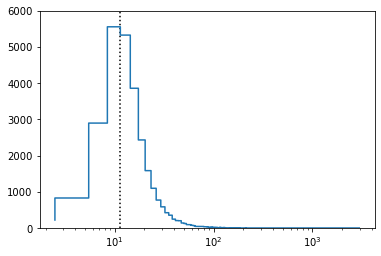

In [650]:
cts = ptsrc['APE_CTS_s'] + ptsrc['APE_CTS_t'] + ptsrc['APE_CTS_u']
hist, bins = np.histogram(cts, bins=1000, range=(1, cts.max()))
x = (bins[:-1]+bins[1:])/2.
plt.step(x, hist)
plt.xscale('log')
plt.vlines(x[np.argmax(hist)], 0, 6000, color='k', linestyle='dotted')
plt.ylim(0,6000)

(0.0, 140.0)

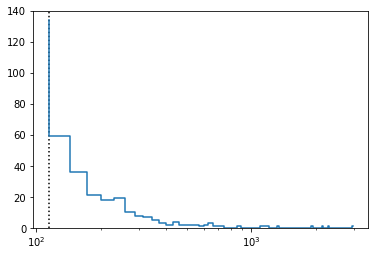

In [653]:
hist, bins = np.histogram(cts, bins=100, range=(100, cts.max()))
x = (bins[:-1]+bins[1:])/2.
plt.step(x, hist)
plt.xscale('log')
plt.vlines(x[np.argmax(hist)], 0, 140, color='k', linestyle='dotted')
plt.ylim(0,140)

In [704]:
def make_regions(catalog, type='grp', maskrad_kpc=None, shape='circle', nannuli=10, maxrad=100, minrad=0, log=False, x=None):
    output = []
    if type == 'gal':
        ra = catalog['ra']*u.degree
        dec = catalog['dec']*u.degree
    elif type in ['grp', 'pts']:
        ra = catalog['RA']*u.degree
        dec = catalog['DEC']*u.degree
    else:
        print('Invalid type')
    if type == 'pts':
        rad = catalog['APE_RADIUS_s']*4*u.arcsec.to('arcmin')
    elif type == 'grp':
        rad = catalog['R_SNR_MAX_ARCMIN']*u.arcmin.to('arcmin')
    else: 
        try:
            dA = lcdm.angular_diameter_distance(catalog['redshift']).to('kpc').value #kpc per radian
        except KeyError:
            dA = lcdm.angular_diameter_distance(catalog['z'].value).to('kpc').value
        dA *= u.arcmin.to('radian') #kpc per arcmin
    for i in range(len(catalog)): 
        c = SkyCoord(ra[i], dec[i])
        r, d = c.to_string('hmsdms').split(' ')
        r = r.replace('h',':').replace('m',':').replace('s','')
        d = d.replace('d',':').replace('m',':').replace('s','')
        if shape == 'circle':
            if type =='gal':
                rad = maskrad_kpc/dA[i]
            output.append(shape+"(%s,%s,%0.5f')" % (r,d,rad[i]))
        elif shape == 'annulus':
            if x:
                bins = x/dA[i]
            else:
                if log:
                    if not minrad:
                        minrad = 1
                    bins = (10**np.linspace(np.log10(minrad), np.log10(maxrad), nannuli+1))/dA[i]
                else:
                    bins = np.linspace(minrad, maxrad, nannuli+1)/dA[i]
            for i in range(len(bins)-1):
                output.append(shape+"(%s,%s,%0.5f',%0.5f')" % (r,d,bins[i],bins[1+i]))
        else:
            print('Invalid shape')
    return output

In [8]:
grpmask = make_regions(grpcat, type='grp', shape='circle')

In [9]:
ptsmask = make_regions(ptsrc, type='pts', shape='circle')

In [11]:
with open('ptsrc.reg','w') as f:
    f.writelines(ptsmask)

In [40]:
# ptsmask_lowsig = make_regions(ptsrc_lowsig, type='pts')

In [3]:
sdss = ascii.read('../SDSS/sdss_output.csv', delimiter=',')
# sdss = sdss[(sdss['logMass'] > 10.2)*(sdss['logMass'] < 11.2)]
# sdss = ascii.read('../Skyserver_SQL2_3_2022 5_42_08 PM.csv', delimiter=',')
sdss.keys()

['ra', 'dec', 'z', 'logMass', 'ssfr']

In [4]:
mass1 = (sdss['logMass'] > 10.2)*(sdss['logMass'] < 10.7)
mass2 = (sdss['logMass'] > 10.7)*(sdss['logMass'] < 11.2)
len(sdss[mass1]), len(sdss[mass2]), len(sdss)

(1482, 1161, 4194)

In [1006]:
x = [0,5.5,10,20,40, 60, 100,150]
annuli = make_regions(sdss, type='gal', maskrad_kpc=None, shape='annulus', nannuli=1, log=True, x=x)

In [1007]:
with open('../gals_broad_bins.reg','w') as f:
    f.writelines(annuli)

# Galaxy Properties

In [981]:
sdss['ssfr'].min(), sdss['ssfr'].max()

(-33.0, -0.282896220684052)

[0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06
 0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1  ]
0.06747351423462089


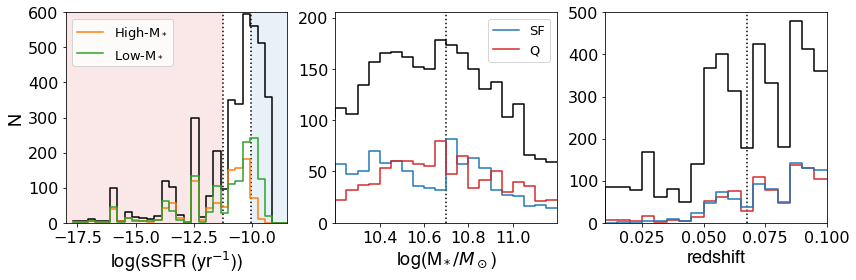

In [852]:
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
font = mpl.font_manager.FontProperties(family='helvetica', size=18)

low = sdss[(sdss['logMass'] < 10.7)*(sdss['logMass'] > 10.2)]
high = sdss[(sdss['logMass'] > 10.7)*(sdss['logMass'] < 11.2)]

fig, ax = plt.subplots(ncols = 3, figsize=(12,4))
ax1, ax2, ax3 = ax.flatten()
for a in (ax1, ax3): a.set_ylabel('N', fontsize=20, font=font)
    
hist, bins = np.histogram(sdss['ssfr']-9, bins=30, range=(-18,-8.5))
ax1.step(bins[1:], hist, color='k')

hist, bins = np.histogram(high['ssfr']-9, bins=30, range=(-18,-8.5))
ax1.step(bins[1:], hist, color='tab:orange', label=r'High-M$_*$')
hist, bins = np.histogram(low['ssfr']-9, bins=30, range=(-18,-8.5))
ax1.step(bins[1:], hist, color='tab:green', label=r'Low-M$_*$')
ax1.legend(loc='best',fontsize=13)

ax1.set_xlabel(r'log(sSFR (yr$^{-1}$))', fontsize=16, font=font)

q = np.argsort(sdss['ssfr'])[int(len(sdss)/3.)]
sf = np.argsort(sdss['ssfr'])[int(2*len(sdss)/3.)]
sfr1 = sdss['ssfr'][q] -9
sfr2 = sdss['ssfr'][sf] -9
ax1.vlines(sfr2, 0, 900, color='k', linestyle='dotted')
ax1.vlines(sfr1, 0, 900, color='k', linestyle='dotted')
ax1.bar(sfr2, 900, width=(1-sfr2), align='edge', alpha=0.1, color='tab:blue')
ax1.bar(sfr1, 900, width=(sfr1-10), align='edge', alpha=0.1, color='tab:red')
ax1.set_xlim(-18,-8.5)
ax1.set_ylim(0,600)

q1 = np.argsort(low['ssfr'])[:int(len(low)/3.)]
sf1 = np.argsort(low['ssfr'])[int(2*len(low)/3.):]
q2 = np.argsort(high['ssfr'])[:int(len(high)/3.)]
sf2 = np.argsort(high['ssfr'])[int(2*len(high)/3.):]

hist, bins = np.histogram(sdss['logMass'], bins=21, range=(10.15,11.2))
ax2.step(bins[1:], hist, color='k')
hist, bins = np.histogram(np.concatenate((low['logMass'][sf1], high['logMass'][sf2])), bins=21, range=(10.15,11.2))
ax2.step(bins[1:], hist, color='tab:blue', label='SF')
hist, bins = np.histogram(np.concatenate((low['logMass'][q1], high['logMass'][q2])), bins=21, range=(10.15,11.2))
ax2.step(bins[1:], hist, color='tab:red', label='Q')
ax2.vlines(x=10.7,ymin=0,ymax=485,color='k',linestyles='dotted')
ax2.set_ylim(0,205)
ax2.set_xlabel(r'log(M$_*/M_\odot$)', fontsize=16,font=font)
ax2.set_xlim(10.2,11.2)
ax2.legend(loc='best',fontsize=13)
ax2.set_xticks([10.4, 10.6, 10.8, 11.0])

zmean = np.mean(sdss['z'][(sdss['z'] > 0.01)*(sdss['z'] < 0.1)])
ax3.vlines(x=zmean,ymin=0,ymax=500,color='k',linestyles='dotted')
hist, bins = np.histogram(sdss['z'], bins=19, range=(0.005,0.1))
ax3.step(bins[1:], hist, color='k')
hist, bins = np.histogram(np.concatenate((low['z'][q1], high['z'][q2])), bins=19, range=(0.005,0.1))
ax3.step(bins[1:], hist, color='tab:red')
hist, bins = np.histogram(np.concatenate((low['z'][sf1], high['z'][sf2])), bins=19, range=(0.005,0.1))
print(bins)
ax3.step(bins[1:], hist, color='tab:blue')
ax3.set_xticks([0.025, 0.05, 0.075, 0.1])
ax3.set_xlim(0.01,0.1)

bins[np.argmax(hist)]
ax3.set_xlabel(r'redshift', fontsize=16, font=font)
ax3.set_ylim(0,500)

for a in ax.flatten(): ama = a.get_ylim()[1]; a.set_ylim(0,ama)
for a in [ax2,ax3]: a.set_ylabel('')


fig.tight_layout()
print(zmean)


In [817]:
(sdss['ssfr']+sdss['logMass']).max() #that's 10^10 solar masses. ok, Ben is right. 

10.43240697973547

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(8,4))
ax1.scatter( sdss['u'],sdss['u'] - sdss['g'])
ax1.set_ylabel('u - g ')
ax1.set_xlabel('u')
ax2.scatter( sdss['g'],sdss['g'] - sdss['r'])
ax2.set_ylabel('g - r ')
ax2.set_xlabel('g')

In [101]:
grpoutput = []
for line in grpmask:
    grpoutput.append (line.replace('h',':').replace('m',':').replace('s ',',').replace('s,',',').replace('"','').replace('d',':'))

ptoutput = []
for line in ptsmask:
    ptoutput.append(line.replace('h',':').replace('m',':').replace('s ',',').replace('s,',',').replace('"','').replace('d',':'))
    
ptoutput_lowsig = []
for line in ptsmask_lowsig:
    ptoutput_lowsig.append(line.replace('h',':').replace('m',':').replace('s ',',').replace('s,',',').replace('"','').replace('d',':'))

In [106]:
with open('grp_cat.reg','w') as f:
    f.writelines(grpoutput)
    
with open('ptsrc_cat.reg','w') as f:
    f.writelines(ptoutput)
    
with open('ptsrc_cat_lowsig.reg','w') as f:
    f.writelines(ptoutput_lowsig)

In [8]:
def radec_to_pix(ra, dec, head):
    
    ra0 = head['CRVAL1']  #  =  1.3386000000000E+02                                                  
    rap0 = head['CRPIX1'] #  =  1.1249500000000E+04                                                  
    dra = head['CDELT1']  #  = -1.1111111276679E-03                                                  
    dec0 = head['CRVAL2'] #  =  1.5000000000000E+00                                                  
    decp0 = head['CRPIX2']#  =  7.4995000000000E+03                                                  
    ddec = head['CDELT2'] #  =  1.1111111276679E-03  
    
    rapix = (ra - ra0)/dra + rap0
    decpix = (dec - dec0)/ddec + decp0
    
    return rapix, decpix

In [11]:
img = fits.getdata('../img_0520_12346_excl_grp_pts.fits')
head = fits.getheader('../img_0520_12346_excl_grp_pts.fits')
rapix, decpix = radec_to_pix(sdss['ra'], sdss['dec'], head)

In [12]:
rapix.min(), rapix.max(), decpix.min(), decpix.max(), img.shape

(-1825.7662317734885,
 16110.9312767981,
 7521.038783732083,
 14047.617266132376,
 (19999, 19999))

In [17]:
ratix = np.array([125,130,135,140,145])
dectix = np.array([-2,0,2,4,6])
xtix, ytix = radec_to_pix(ratix, dectix, head)

c = SkyCoord(ra=ratix*u.deg, dec=dectix*u.deg)

(3000.0, 12000.0)

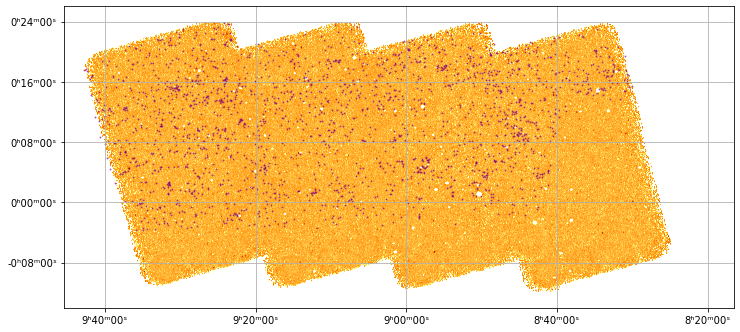

In [22]:
fig, ax = plt.subplots(figsize=(12,36))
plt.imshow(img,origin='lower',cmap=cm.afmhot_r, norm=colors.LogNorm(img.max()/1e6,img.max()))
plt.scatter(rapix, decpix, color='purple', alpha=0.5, s=1)
plt.xticks(xtix, c.ra.to_string(unit=u.hourangle, fields=3, format='unicode'))
plt.yticks(ytix, c.dec.to_string(unit=u.hourangle, fields=3, format='unicode'))
plt.grid(True)
plt.ylim(3000,12000)

In [33]:
def crossmatch(gal_region_file, sdss, tab=False, arr=False):
	#gal_region_file contains the dmcopy or dmextract regions
	#sdss is a table
	inds = []
	if tab:
		for i in range(len(gal_region_file)):
			inds.append(np.argmin(abs(sdss['ra'] - gal_region_file['ra'].iloc[i]) + abs(sdss['dec'] - gal_region_file['dec'].iloc[i])))
	elif arr:
		for i in range(len(gal_region_file)):
			inds.append(np.argmin(abs(sdss['ra'] - gal_region_file[i,0]) + abs(sdss['dec'] - gal_region_file[i,1])))
	else:
		with open(gal_region_file) as f:
			a = f.readlines()
		c = a[::15]
		print(len(a), len(b), len(c))
		tra = [l.split('(')[1].split(',')[0] for l in c]
		tdec = [l.split(',')[1] for l in c]
		for i in range(len(tra)):
			radec = SkyCoord(tra[i]+' '+tdec[i], unit=(u.hourangle, u.deg))
			inds.append(np.argmin(abs(sdss['ra'] - radec.ra.to('deg').value) + abs(sdss['dec'] - radec.dec.to('deg').value)))
	return inds


In [24]:
def make_stack(maskmin, maskmax, df, field='logMass'):
    mask = (df[field] > maskmin)*(df[field] < maskmax)
    stack = df[mask]
    return stack 

# Stacked images

In [6]:
def stacked_image(files, lenx, leny, inputtype='file'):
	img = np.zeros((lenx, leny))
	i = 0
	for file in files:
		if inputtype == 'file':
			f = fits.getdata(file)
		else:
			f = file
		x, y = f.shape
		# print(x,y)
		if y:
			starty = int((leny - y)/2)
			endy = starty+y
			startx = int((lenx - x)/2)
			endx = startx+x
			img[startx:endx,starty:endy] += f
	return ndimage.gaussian_filter(img, sigma=1, order=0)

In [7]:
lowstack = fits.getdata('../lowmass_stack.fits')
highstack = fits.getdata('../highmass_stack.fits')

In [8]:
def annulus(array, rmin, rmax):
    x = np.arange(array.shape[0])
    y = np.arange(array.shape[1])
    x = x - x.mean()
    y = y - y.mean()
    X, Y = np.meshgrid(x,y)
    r2 = X**2 + Y**2 
    return np.ma.masked_inside(r2, rmin**2, rmax**2).mask

In [9]:
bck_inds = annulus(lowstack, 25, 37.5)
low_bck = np.nanmedian(lowstack[bck_inds])
high_bck = np.nanmedian(highstack[bck_inds])
# print(np.nanmean(low_bck), np.nanmedian(low_bck), np.nanmean(lowstack), np.nanmedian(lowstack))

<ipython-input-376-7eab770acb7b>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,0.8,1])


Text(0.5, 91.25045454545455, 'X (")')

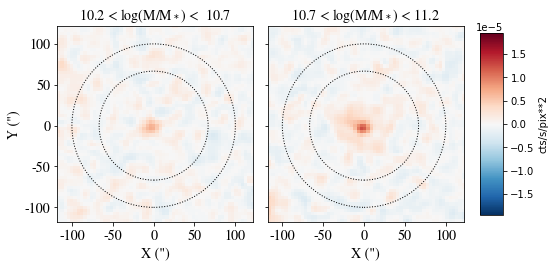

In [376]:
imlo = lowstack - low_bck
imhi = highstack - high_bck
zmin = min(imlo.min(), imhi.min())
zmax = max(imlo.max(), imhi.max())
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8,6))
ax1, ax2 = ax.flatten()
im = ax1.imshow(imlo, norm = colors.Normalize(-zmax, zmax), cmap=cm.RdBu_r)
ax2.imshow(imhi, norm = colors.Normalize(-zmax, zmax), cmap=cm.RdBu_r)
xtix = [-100,-50,0,50,100]
xpos = np.array(xtix)/4
xmean = np.mean(ax1.get_xlim())
xpos += xmean
ax1.set_yticks(xpos)
ax1.set_yticklabels(xtix,fontsize=14,fontfamily='STIXGeneral')
ax1.set_xticks(xpos)
ax1.set_xticklabels(xtix,fontsize=14,fontfamily='STIXGeneral')
ax2.set_xticks(xpos)
ax2.set_xticklabels(xtix,fontsize=14,fontfamily='STIXGeneral')
ax1.set_title(r'10.2 < log(M/M$_*$) <  10.7', fontfamily= 'STIXGeneral', fontsize=14)
ax2.set_title(r'10.7 < log(M/M$_*$) < 11.2', fontfamily= 'STIXGeneral', fontsize=14)
plt.xlim(45.5,105.5)
plt.ylim(45.5,105.5)
for a in [ax1, ax2]:
    src_circle = plt.Circle((xmean, xmean), 25, fill=False, color='k', linestyle='dotted')
    bck_circle = plt.Circle((xmean, xmean), 37.5, fill=False, color='k', linestyle='dotted')
    a.add_artist(src_circle)
    a.add_artist(bck_circle)
cb_ax = fig.add_axes([0.81,0.29,0.04,0.42])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('cts/s/pix**2')
fig.tight_layout(rect=[0,0,0.8,1])
ax1.set_xlabel('X (")',fontsize=14,fontfamily= 'STIXGeneral')
ax1.set_ylabel('Y (")',fontsize=14,fontfamily= 'STIXGeneral')
ax2.set_xlabel('X (")',fontsize=14,fontfamily= 'STIXGeneral')

# Split above image by sSFR

In [12]:
src0520 = pd.read_csv('../src_bck_cts.csv').drop('Unnamed: 0', axis=1)
src0510 = pd.read_csv('../src_bck_cts_0510.csv').drop('Unnamed: 0', axis=1)

inds1 = crossmatch(src0520, sdss, tab=True, arr=True)
inds2 = crossmatch(src0510, sdss, tab=True, arr=True)

In [13]:
# src0520.insert(2, 'logMass', sdss[inds1]['logMass'])
# src0520.insert(3, 'ssfr', sdss[inds1]['ssfr'])
# src0520.insert(4, 'z', sdss[inds1]['z'])
# src0510.insert(2, 'logMass', sdss[inds2]['logMass'])
# src0510.insert(3, 'ssfr', sdss[inds2]['ssfr'])
# src0510.insert(4, 'z', sdss[inds2]['z'])

src0520, src0510

(              ra       dec    logMass      ssfr         z        cts     area  \
 0     135.120514  1.287257  10.570845 -2.551323  0.071391  18.000000  15760.0   
 1     135.119109  1.213715  10.332455 -1.041963  0.070364  26.000000  16128.0   
 2     138.547110  0.818210  10.670558 -0.818822  0.055075  39.967085  25440.0   
 3     143.428977  1.288796  10.382001 -0.809493  0.087693   9.000000  10832.0   
 4     143.412123  1.629883  10.225363 -4.542106  0.073173  15.366893  15088.0   
 ...          ...       ...        ...       ...       ...        ...      ...   
 2116  132.104039  5.267658  10.818737 -1.278401  0.072350   1.000000  15376.0   
 2117  132.129329  4.068789  11.147572 -4.969607  0.078301  12.983837  10928.0   
 2118  135.521079  4.455544  11.044790 -1.513577  0.095079  20.000000   9296.0   
 2119  137.313246  5.656724  10.950965 -2.671447  0.058400  16.061539  22160.0   
 2120  140.010041  4.000699  10.792123 -1.422363  0.097873   7.790740   8880.0   
 
              

# Hardness Ratios

In [417]:
def net_cts(src):
    bck_med = np.nanmedian(src['bck_cts']/(src['bck_area']*src['bck_exp']))
    return src['cts'] - bck_med*src['exp']*src['area']

In [418]:
#this is 1.0-2.0 / 0.5-1.0 keV
net_cts(src0520).sum()/net_cts(src0510).sum() - 1

0.44549034788672914

In [461]:
low_hardness = net_cts(src0520[src0520['logMass'] < 10.7]).sum()/net_cts(src0510[src0510['logMass'] < 10.7]).sum() - 1
high_hardness = net_cts(src0520[src0520['logMass'] > 10.7]).sum()/net_cts(src0510[src0510['logMass'] > 10.7]).sum() - 1

Text(0.5, 1.0, 'Low mass stack')

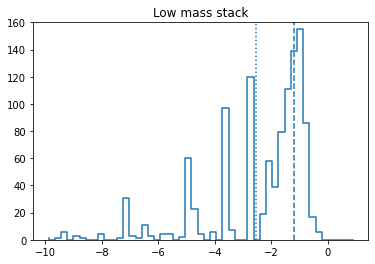

In [477]:
def sfrhist(table, cut, plot=True, color='tab:blue'):
    sfr = table.values[cut]
    hist, bins = np.histogram(sfr, bins=50, range=(-10,1))
    sort = np.argsort(sfr)
    cut1 = sfr[sort[int(len(sfr)/3.)]]
    cut2 = sfr[sort[int(2*len(sfr)/3.)]]
    if plot:
        plt.step((bins[1:]+bins[:-1])/2., hist)
        plt.ylim(0,160)
        plt.vlines(cut1, 0, 160, linestyle='dotted', color=color)
        plt.vlines(cut2, 0, 160, linestyle='dashed', color=color)
    return np.argwhere(sfr > cut2)[:,0], np.argwhere(sfr < cut1)[:,0]

top1, bottom1 = sfrhist(src0520['ssfr'],(src0520['logMass'] < 10.7))
plt.title('Low mass stack')

(0.0, 110.0)

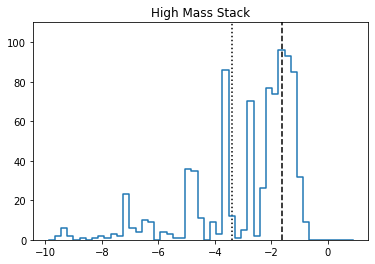

In [455]:
top2, bottom2 = sfrhist(src0520['ssfr'],(src0520['logMass'] > 10.7))
plt.title('High Mass Stack')
plt.ylim(0,110)

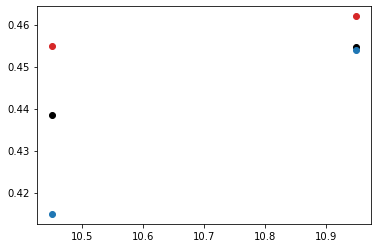

In [462]:
high_sf_hardness = net_cts(src0520[src0520['logMass'] > 10.7].iloc[top2]).sum()/net_cts(src0510[src0510['logMass'] > 10.7].iloc[top2]).sum() - 1
high_q_hardness = net_cts(src0520[src0520['logMass'] > 10.7].iloc[bottom2]).sum()/net_cts(src0510[src0510['logMass'] > 10.7].iloc[bottom2]).sum() - 1
low_sf_hardness = net_cts(src0520[src0520['logMass'] < 10.7].iloc[top1]).sum()/net_cts(src0510[src0510['logMass'] < 10.7].iloc[top1]).sum() - 1
low_q_hardness = net_cts(src0520[src0520['logMass'] < 10.7].iloc[bottom1]).sum()/net_cts(src0510[src0510['logMass'] < 10.7].iloc[bottom1]).sum() - 1
Mstar = [(10.2+10.7)/2., (10.7+11.2)/2.]
plt.scatter(Mstar, [low_hardness, high_hardness], color='k')
plt.scatter(Mstar, [low_sf_hardness, high_sf_hardness], color='tab:blue')
plt.scatter(Mstar, [low_q_hardness, high_q_hardness], color='tab:red')

247 248 279 275 165 161


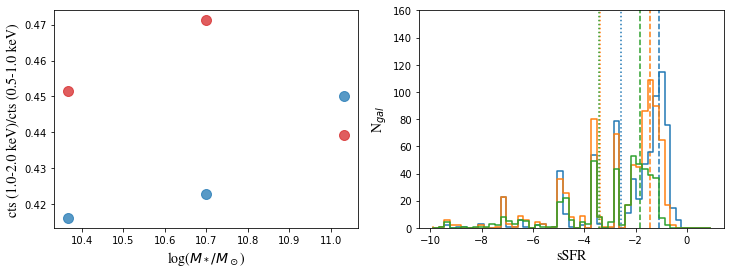

In [481]:
cut1 = (src0520['logMass'] < 10.533)
cut2 = (src0520['logMass'] > 10.533)*(src0520['logMass'] < 10.867)
cut3 = (src0520['logMass'] > 10.866)
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
top1, bottom1 = sfrhist(src0520['ssfr'], cut1)#, plot=False)
top2, bottom2 = sfrhist(src0520['ssfr'], cut2, color='tab:orange')#, plot=False)
top3, bottom3 = sfrhist(src0520['ssfr'], cut3, color='tab:green')#, plot=False)
sf_hardness1 = net_cts(src0520[cut1].iloc[top1]).sum()/net_cts(src0510[cut1].iloc[top1]).sum() - 1
q_hardness1 = net_cts(src0520[cut1].iloc[bottom1]).sum()/net_cts(src0510[cut1].iloc[bottom1]).sum() - 1
sf_hardness2 = net_cts(src0520[cut2].iloc[top2]).sum()/net_cts(src0510[cut2].iloc[top2]).sum() - 1
q_hardness2 = net_cts(src0520[cut2].iloc[bottom2]).sum()/net_cts(src0510[cut2].iloc[bottom2]).sum() - 1
sf_hardness3 = net_cts(src0520[cut3].iloc[top3]).sum()/net_cts(src0510[cut3].iloc[top3]).sum() - 1
q_hardness3 = net_cts(src0520[cut3].iloc[bottom3]).sum()/net_cts(src0510[cut3].iloc[bottom3]).sum() - 1
Mstar = [(10.2+10.533)/2., 10.7, (10.867+11.2)/2.]
# plt.scatter(Mstar, [low_hardness, high_hardness], color='k')
ax[0].scatter(Mstar, [sf_hardness1, sf_hardness2, sf_hardness3], color='tab:blue', alpha=0.75, s=100)
ax[0].scatter(Mstar, [q_hardness1, q_hardness2, q_hardness3], color='tab:red', alpha=0.75, s=100)
ax[0].set_ylabel('cts (1.0-2.0 keV)/cts (0.5-1.0 keV)', fontsize=14, fontfamily='STIXGeneral')
ax[0].set_xlabel(r'log($M_*/M_\odot$)', fontsize=14, fontfamily='STIXGeneral')

ax[1].set_xlabel('sSFR', fontsize=14, fontfamily='STIXGeneral')
ax[1].set_ylabel(r'N$_{gal}$', fontsize=14, fontfamily='STIXGeneral')
print(len(top1), len(bottom1), len(top2), len(bottom2), len(top3), len(bottom3))

# Mass-Luminosity Relation

In [340]:
from scipy.optimize import curve_fit
from scipy.integrate import quad

path='../' #/data/gnarming/uchadaya/eFEDS/ if on hea comp
cdf = np.mean(np.mean(fits.getdata(path+'psf1.fits'), axis=1), axis=1)
eef = np.arange(0.4, 1.0, 0.05)
sb = eef/(np.pi*cdf**2)
area = np.pi * (cdf[1:]**2 - cdf[:-1]**2)
dE = eef[1:] - eef[:-1]
sb[1:] = dE / area
sb /= sb[0]
xcdf = (cdf[1:] + cdf[:-1])/2
xcdf = np.insert(xcdf,0,cdf[0]/2)
xcdf *= (4 * 1.45)

# print(xcdf, eef, sb)
def psf_curve(r, A, rs, beta):
	return A * (1 + (r/rs)**2)**(-beta) #Moffat function, beta=2.0 fitted for XMM

def psf_area(r, A, rs, beta): 
	#integrating this from r1 to r2 should give me the fraction of photons enclosed between those radii
		#IF THE PSF IS PROPERLY NORMALISED
		#in other words, integrating this gives the factor that the raw PSF should be normalised by. 
	return 2*np.pi*r * psf_curve(r, A, rs, beta) #

fit, _ =  curve_fit(psf_curve, xcdf, sb)
area_psf, _ = quad(psf_area, args=(fit[0],fit[1], fit[2]), a=0, b=np.infty) 
xp = np.arange(0,100,.1)
yp = psf_curve(xp, *fit)/area_psf

# def Lxrb(sdss, alpha = 9.05e28, beta = 1.62e39, low=False, high=False):  #alpha in erg/s/Msun, beta in erg/s/Msun/yr)
# 	# Lehmer et al. 2010
# 	dalpha = 0.37e28
# 	dbeta = 0.22e39
# 	if low:
# 		alpha -= dalpha
# 		beta -= dbeta
# 	if high:
# 		alpha += dalpha 
# 		beta += dbeta
# 	mstar = 10**sdss['logMass']
# 	sfr = 10**(sdss['ssfr'] - 9) * mstar #the -9 converts from Msun/Gyr to Msun/yr
# 	return alpha*mstar + beta*sfr

def Lxrb(sdss, alpha = 6.713e+28, beta = 2.552e+39, low=False, high=False):  #alpha in erg/s/Msun, beta in erg/s/Msun/yr)
	# Lehmer et al. 2019
    #their values are for 0.5-8keV. I use PIMMS to convert this to 0.5-2.0 keV, for ACIS, APEC using photon index = 1.7
    #ok now note. **This beta is too high.** In all the analyses use Mineo instead, 1.62e39. 
	if low:
		alpha = 5.983672482257647e+28, 
		beta = 1.8922033816407476e+39
	if high:
		alpha = 7.888016571050706e+28
		beta = 3.605519214113673e+39
	mstar = 10**sdss['logMass']
	sfr = 10**(sdss['ssfr'] - 9) * mstar #the -9 converts from Msun/Gyr to Msun/yr
	return alpha*mstar + beta*sfr


In [341]:
fit[1]/1.45, fit[2]

(9.398277230033958, 1.5941697810277116)

In [76]:
gals = ascii.read('../src_bck_cts.csv', delimiter=',', header_start=0)

In [9]:
eagle0510 = np.vstack((np.genfromtxt('../BenData/EAGLE_High-Mass.0.5_1.0keV.list.cat'), np.genfromtxt('../BenData/EAGLE_Low-Mass.0.5_1.0keV.list.cat')))
eagle1020 = np.vstack((np.genfromtxt('../BenData/EAGLE_High-Mass.1.0_2.0keV.list.cat'), np.genfromtxt('../BenData/EAGLE_Low-Mass.1.0_2.0keV.list.cat')))
tng0510 = np.vstack((np.genfromtxt('../BenData/TNG_High-Mass.0.5_1.0keV.list.cat'), np.genfromtxt('../BenData/TNG_Low-Mass.0.5_1.0keV.list.cat')))
tng1020 = np.vstack((np.genfromtxt('../BenData/TNG_High-Mass.1.0_2.0keV.list.cat'), np.genfromtxt('../BenData/TNG_Low-Mass.1.0_2.0keV.list.cat')))

Lx_tng = 10**tng0510[:,-3]   + 10**tng1020[:,-3]
Lx_eag = 10**eagle0510[:,-3] + 10**eagle1020[:,-3]
mtng = tng0510[:,3]
meag = eagle0510[:,3]

In [10]:
def sort(sdss):
    q = np.argsort(sdss['ssfr'])[:int(len(sdss)/3.)]
    sf = np.argsort(sdss['ssfr'])[int(2*len(sdss)/3.):]
    try: 
        return sf.values, q.values
    except AttributeError:
        return sf, q

In [528]:
high = gals['logMass'] > 10.7
highsf, highq = sort(gals[high])
xp, yp, norm = xrb_psf(gals[high][highsf], beta=1.62e39)
fit_xrb     = fit[0]*norm/area_psf
quad(psf_area, a=0, b=np.inf,args=(fit_xrb, fit[1], fit[2])), norm 

((1.3016097220875518e+40, 1.634225391027695e+32), 1.3016097220875518e+40)

So see, the integral does indeed yield the total luminosity between a and b

In [488]:
# def Lx_stack(table, rmin=10,rmax=100, xrb=False, alpha=6.71e28, beta=2.552e39, cts_to_erg=1.624e-12, 
#              fit=fit, area_psf = area_psf, zmean=False):

#     dl      = lcdm.luminosity_distance(table['z']).to('cm').value #for luminosity distance
#     dcorr   = 4*np.pi*(dl**2)                                    
#     bkg_rt  = (table['bck-cts']/(table['bck-area']*table['bck-exp']))
#     bkg_rt = np.nanmedian(bkg_rt[bkg_rt > 0])
# #     print(bkg_rt)
#     net_cts = table['cts'] - (bkg_rt*table['area']*table['exp'])
#     valid = (net_cts > -10)
#     net_cts = net_cts[valid]; dcorr = dcorr[valid]; table=table[valid]
# #     if xrb:
# #         norm        = Lxrb(table, beta=beta,alpha=alpha).mean()
# #         fit_xrb     = fit[0]*norm/area_psf
# #         lxrb, _     = quad(psf_area, a=rmin, b=rmax,args=(fit_xrb, fit[1], fit[2]))
# #         xrb_cts_sec = lxrb *np.nanmean(table['exp']/dcorr)/(cts_to_erg)
# #         Lx         -= np.nansum(lxrb)
#     if xrb:
#             norm        = Lxrb(table, beta=beta,alpha=alpha).mean()
#             fit_xrb     = fit[0]*norm/area_psf
#             lxrb, _ = quad(psf_area, a=10, b=100,args=(fit_xrb, fit[1], fit[2])) 
#             dA = lcdm.angular_diameter_distance(table['z']).to('kpc').value*u.arcsec.to('radian')
#             ar = table['area']*(dA**2)/400
#             ratio = np.nanmean(ar)/(np.pi*(100**2 - 100))
# #             lxrb *= ratio
#             print(ratio, lxrb)
#             xrb_cts = lxrb*np.nanmean(table['exp'])/(cts_to_erg * dcorr.mean()) #photons
# #             print(np.nansum(net_cts), xrb_cts)
#             net_cts -= xrb_cts
# #         print(norm, np.nansum(lxrb))
#     if zmean:
# #         Lx      = np.nanasum(net_cts*dcorr) / np.nansum(table['exp']) * cts_to_erg 
#     else:
#         Lx      = np.nansum(net_cts) / np.nansum(table['exp']) * cts_to_erg * dcorr.mean()
#     binerr = np.sqrt(np.nansum(table['cts']))/np.nansum(net_cts)
#     return Lx, binerr

In [513]:
def Lx_stack(tab, xrb=False, alpha = 9.05e28, beta = 1.62e39, cts_to_erg=1.624e-12, 
             fit=fit, area_psf = area_psf):
    cts = tab['cts']
    area = tab['area']
    exp = tab['exp']
    bkg_rt = tab['bck-cts']/(tab['bck-area']*tab['bck-exp'])
    bkg_rt = np.nanmedian(bkg_rt[bkg_rt > 0])
    net_cts = cts - bkg_rt*area*exp
    valid = (net_cts > -10)
    net_cts = net_cts[valid]; cts=cts[valid]; exp=exp[valid]; area=area[valid]; tab=tab[valid]
    dl2 = 4*np.pi*(lcdm.angular_diameter_distance(tab['z']).to('cm'))**2
    Lx = np.nansum(net_cts* dl2.value)/np.nansum(exp) * cts_to_erg 
    if xrb:
        xp, yp, norm = xrb_psf(tab, alpha=alpha, beta=beta)
        dA = np.insert(np.pi*(xp[1:]**2 - xp[:-1]**2), 0, 0)
        mask = (xp > 10)*(xp < 100)
        lxrb = sum(dA[mask]*yp[mask]*norm)
        dA2 = (lcdm.angular_diameter_distance(tab['z']).to('kpc').value*u.arcsec.to('radian'))**2
        ar = np.nanmean(tab['area']*dA2)/400
        ratio = ar/sum(dA[mask])
        lxrb *= ratio
        print(ratio, lxrb, Lx)
        xrb_cts = lxrb*exp/(cts_to_erg * dl2.value)
        net_cts -= xrb_cts

    Lx = np.nansum(net_cts* dl2.value)/np.nansum(exp) * cts_to_erg 
    err = np.sqrt(np.nansum(cts))/np.nansum(net_cts)
    return Lx, err

In [299]:
def scatter(Lx, err, Mleft, Mright, ax, color, label, nsigma=1, alpha=1, lw=2):
    x = (Mleft+Mright)/2.
    xerr = (Mright-Mleft)/2.
    valid = (Lx > 0)*(err < 1)
    ax.errorbar(x[valid], Lx[valid], xerr=xerr[valid], yerr=(Lx*err)[valid], color=color, alpha=alpha, linewidth=0, elinewidth=lw)
    ax.scatter(x[valid], Lx[valid], s=50, color=color, alpha=alpha, label=label)
    ax.scatter(x[~valid], Lx[~valid]*(1+nsigma*err[~valid]), color=color, marker='v', alpha=alpha)

In [813]:
def Lx_Mstar(Mleft, Mright, ax, gals=gals, alpha = 9.05e28, beta = 1.62e39, xrb=True, debug=False,mincts=-1e5,nsigma=1):
    Lx_r  = np.zeros(len(Mleft))
    err_r = np.zeros(len(Mleft))
    Lx_b  = np.zeros(len(Mleft))
    err_b = np.zeros(len(Mleft))

    for i in range(len(Mright)):
#         print(Mleft[i])
        tng = Lx_tng[(mtng > Mleft[i])*(mtng < Mright[i])]
        eag = Lx_eag[(meag > Mleft[i])*(meag < Mright[i])]
        subgals = gals[(gals['logMass'] > Mleft[i])*(gals['logMass'] < Mright[i])]
        top, bottom = sort(subgals)
        #trying a sum over profile

        Lx_b[i], err_b[i] = sb_prof(subgals.iloc[top], xrb=xrb,beta=beta,alpha=alpha, tot=True,mincts=mincts)
        Lx_r[i], err_r[i] = sb_prof(subgals.iloc[bottom], xrb=xrb,beta=beta,alpha=alpha, tot=True, mincts=mincts)

#         Lx_b[i], err_b[i] = Lx_stack(subgals[top],    xrb=True,alpha=alpha, beta=beta)
#         print('Q: ')
#         Lx_r[i], err_r[i] = Lx_stack(subgals[bottom], xrb=True,alpha=alpha, beta=beta)
#         print(err_b, err_r)
        ssfrtng = tng0510[(mtng > Mleft[i])*(mtng < Mright[i])][:,5]
        ssfreag = eagle0510[(meag > Mleft[i])*(meag < Mright[i])][:,5]

        redtng = np.argsort(ssfrtng)[:int(len(tng)/3.)]
        bluetng = np.argsort(ssfrtng)[int(2*len(tng)/3.):]
        redeag = np.argsort(ssfreag)[:int(len(eag)/3.)]
        blueeag = np.argsort(ssfreag)[int(2*len(eag)/3.):]

        ax.scatter((10**Mleft[i]+10**Mright[i])/2., np.nanmean(tng[bluetng]), color='None',edgecolors='tab:blue', marker='X', s=200, alpha=0.75, hatch='///')
        ax.scatter((10**Mleft[i]+10**Mright[i])/2., np.nanmean(eag[blueeag]), color='None',edgecolors='tab:blue', marker='H', s=200, alpha=0.75, hatch='///')
        ax.scatter((10**Mleft[i]+10**Mright[i])/2., np.nanmean(tng[redtng]), color='None',edgecolors='tab:red', marker='X', s=200, alpha=0.75, hatch='///')
        ax.scatter((10**Mleft[i]+10**Mright[i])/2., np.nanmean(eag[redeag]), color='None',edgecolors='tab:red', marker='H', s=200, alpha=0.75, hatch='///')
        if debug:
            print('Sim/obs: ', np.nanmean(tng[bluetng])/Lx_b[i],np.nanmean(eag[blueeag])/Lx_b[i],np.nanmean(tng[redtng])/Lx_r[i],np.nanmean(eag[redeag])/Lx_r[i])
            print('SF/Q TNG, EAG: ', np.nanmean(tng[bluetng])/np.nanmean(tng[redtng]),np.nanmean(eag[blueeag])/np.nanmean(eag[redeag]))

    if debug:
        print(Lx_b, err_b, Lx_r, err_r)
    scatter(Lx_b, err_b, 10**Mleft, 10**Mright, ax=ax, color='tab:blue', nsigma=nsigma, alpha=1, lw=2, label='SF')
    scatter(Lx_r, err_r, 10**Mleft, 10**Mright, ax=ax, color='tab:red', nsigma=nsigma, alpha=1, lw=2, label='Q')

    ax.scatter(1, 1, color='None',edgecolors='k', marker='X', s=200, alpha=0.5, label='TNG', hatch='///')
    ax.scatter(1, 1, color='None',edgecolors='k', marker='H', s=200, alpha=0.5, label='Eagle', hatch='///')
    ax.set_xlim(10**10.1, 10**11.3)

    h, l = ax.get_legend_handles_labels()
    ax.legend(h[-4:],l[-4:], fontsize=12)
    ax.set_yticks([1e38,1e40,1e42])
    ax.set_yticklabels([r'10$^{38}$',r'10$^{40}$',r'10$^{42}$'],fontsize=18, fontfamily='STIXGeneral')
    ax.set_xticklabels(['',r'10$^{10}$',r'10$^{11}$','',''],fontsize=18, fontfamily='STIXGeneral')
    ax.set_xlabel(r'M$_*$ (M$_\odot$)', fontfamily='STIXGeneral', fontsize=18)
    ax.set_ylabel(r'L$_x$ (0.5-2.0 keV) (erg/s)', fontfamily='STIXGeneral', fontsize=18)
    ax.figure.tight_layout()
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel(r'M$_*$ (M$_\odot$)', fontfamily='STIXGeneral', fontsize=18)
    ax.set_ylim(4e38,2.5e41)

Sim/obs:  0.17276098054284514 0.21944284810502507 0.4688310651881092 0.11614891763404345
SF/Q TNG, EAG:  1.5282817204591137 7.835746966328853
Sim/obs:  0.464653706089627 1.2535642661616961 0.13293182040526758 0.23404309724734837
SF/Q TNG, EAG:  9.150758003704402 14.021916740223014
Sim/obs:  4.536911756378681 16.093244573083908 0.3948933749367678 1.2683962476271002
SF/Q TNG, EAG:  16.13184102129232 17.815257817094135
[2.57480768e+40 2.56675314e+40 2.45990792e+40] [0.20301484 0.12920387 0.18308154] [6.20827086e+39 9.80454593e+39 1.75192456e+40] [0.28544615 0.33582172 0.16658844]


<ipython-input-813-0ac9c2e547e0>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',r'10$^{10}$',r'10$^{11}$','',''],fontsize=18, fontfamily='STIXGeneral')


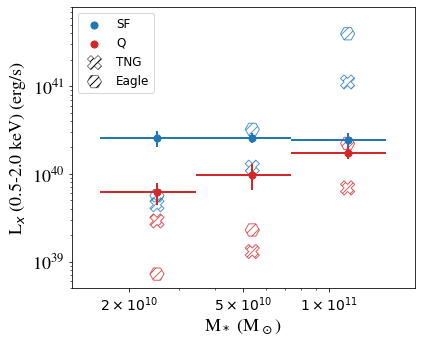

In [830]:
fig, ax = plt.subplots(ncols = 1, figsize=(6,5))
gals = prof0520 #cut
Mleft = np.linspace(10.2, 10.867, 3)
Mright = Mleft + 0.334
Lx_Mstar(Mleft, Mright, ax, gals, xrb=True, alpha=6.713e28, beta=2.55e39,  mincts=-10, debug=True)
# Mleft = np.linspace(10.2, 11, 5)
# Mright = Mleft + 0.2
# Lx_Mstar(Mleft, Mright, ax[1], gals, xrb=True, alpha=6.713e28, beta=2.55e39, mincts=-10)
# Mleft = np.linspace(10.2, 11.075, 8)
# Mright = Mleft + 0.125
# Lx_Mstar(Mleft, Mright, ax[2], gals, xrb=True, alpha=6.713e28, beta=2.55e39, mincts=-10, nsigma=1)#, debug=True)

# for a in [ax[1], ax[2]]: 
#     a.set_ylabel('')
#     a.set_yticklabels([])
# plt.tight_layout()
# for a in ax.flatten(): 
ax.set_ylim(5e38, 8e41)
ax.set_xticks([2e10,5e10,1e11])
ax.set_xticklabels([r'$2\times10^{10}$',r'$5\times10^{10}$',r'$1\times10^{11}$'], fontsize=14)

#fuck YES
sf_q_obs = [4, 2.5, 2]
sf_q_tng = [1.5, 9, 16]
sf_q_eag = [8, 14, 18]

In [ ]:
# #using old function, commented out above

# # Mleft = np.linspace(10.2, 10.867, 3)
# # Mright = Mleft + 0.334
# fig, ax = plt.subplots(ncols = 3, figsize=(18,6))
# gals = ascii.read('../src_bck_cts.csv',delimiter=',',header_start=0)
# # Lx_Mstar(Mleft, Mright, ax[0], gals,xrb=False, alpha=0, beta=0, zmean=False)
# # ax[0].set_title('Raw, mean z')
# Lx_Mstar(Mleft, Mright, ax[0], gals, xrb=True, alpha=0, beta=0, zmean=False)
# ax[0].set_title(r'Raw, z$_{gal}$')
# Lx_Mstar(Mleft, Mright, ax[1], gals, xrb=True, beta=0, zmean=False)
# ax[1].set_title('LMXB corrected')
# Lx_Mstar(Mleft, Mright, ax[2], gals, xrb=True, zmean=False, beta=1.62e39)
# ax[2].set_title('All XRB corrected')
# for a in [ax[1], ax[2]]: 
#     a.set_ylabel('')
#     a.set_yticklabels([])
# plt.tight_layout()

<ipython-input-813-0ac9c2e547e0>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',r'10$^{10}$',r'10$^{11}$','',''],fontsize=18, fontfamily='STIXGeneral')


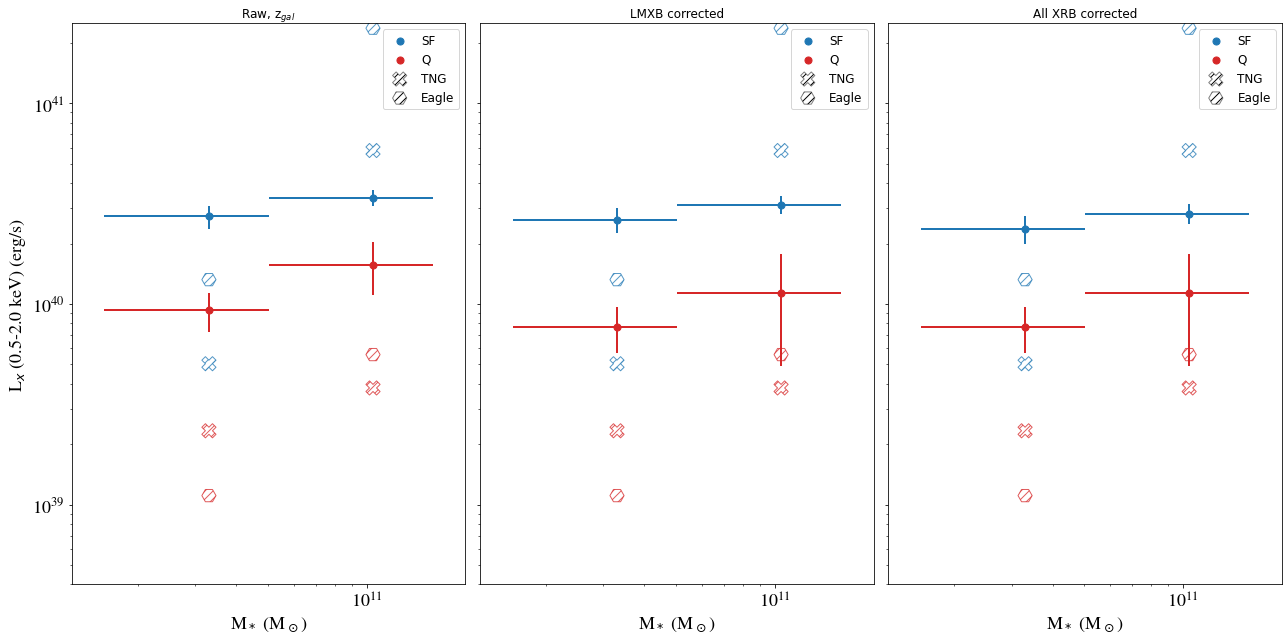

In [906]:
Mleft = np.array([10.2, 10.7])#np.linspace(10.2, 10.867, 3)
Mright = Mleft + 0.5
fig, ax = plt.subplots(ncols = 3,nrows=1, figsize=(18,9))
gals = prof0520
Lx_Mstar(Mleft, Mright, ax[0], gals, xrb=False, alpha=0, beta=0, mincts=-100)
ax[0].set_title(r'Raw, z$_{gal}$')
Lx_Mstar(Mleft, Mright, ax[1], gals, xrb=True, beta=0, mincts=-100)
ax[1].set_title('LMXB corrected')
Lx_Mstar(Mleft, Mright, ax[2], gals, xrb=True, beta=1.62e39, mincts=-100)
ax[2].set_title('All XRB corrected')

# Lx_Mstar(Mleft, Mright, ax[1][0], gals, xrb=False, alpha=0, beta=0, mincts=0)
# Lx_Mstar(Mleft, Mright, ax[1][1], gals, xrb=True, beta=0, mincts=0)
# Lx_Mstar(Mleft, Mright, ax[1][2], gals, xrb=True, beta=1.62e39, mincts=0)

for a in [ax[1], ax[2]]: 
    a.set_ylabel('')
    a.set_yticklabels([])
# for a in ax[0].flatten():
#     a.set_xlabel('')
#     a.set_xticklabels([])
plt.tight_layout()

#fuck YES

The really important question now is what changed. How did I go from having SF galaxies be brighter to, now, dimmer?
Well, for one, the Lehmer alpha and especially beta are higher. But I checked using the Mineo values, and still Q is brighter than SF now. 
I think the SF/Q sorting was broken. Remember yesterday - the "SF" indices sometimes had 0 sfr,and the Q sometimes >1/yr. 

In [661]:
def sb_bkg(tab):
    cts_to_erg = 1.624e-12
    dl2 = 4*np.pi*lcdm.angular_diameter_distance(tab['z']).to('cm')**2
    return np.nanmedian(tab['bck-cts']/(tab['bck-area']*tab['bck-exp'])) *dl2.mean() * cts_to_erg

-1.20312941074371 -2.55801248550415 -1.61841905117035 -3.42206788063049
HXMB
[[ 0.00000000e+00  5.50000000e+00  5.26983707e+36  5.12356773e-01]
 [ 5.50000000e+00  1.00000000e+01  4.75287730e+36  4.19121182e-01]
 [ 1.00000000e+01  2.00000000e+01  2.27615690e+36  7.82720541e-01]
 [ 2.00000000e+01  4.00000000e+01  1.73469469e+36  7.48705289e-01]
 [ 4.00000000e+01  6.00000000e+01  1.24914279e+36  3.40873850e-01]
 [ 6.00000000e+01  1.00000000e+02 -7.84905318e+33 -7.02877562e+00]]


Text(6, 3.5e+34, 'log(sSFR) < -3.42')

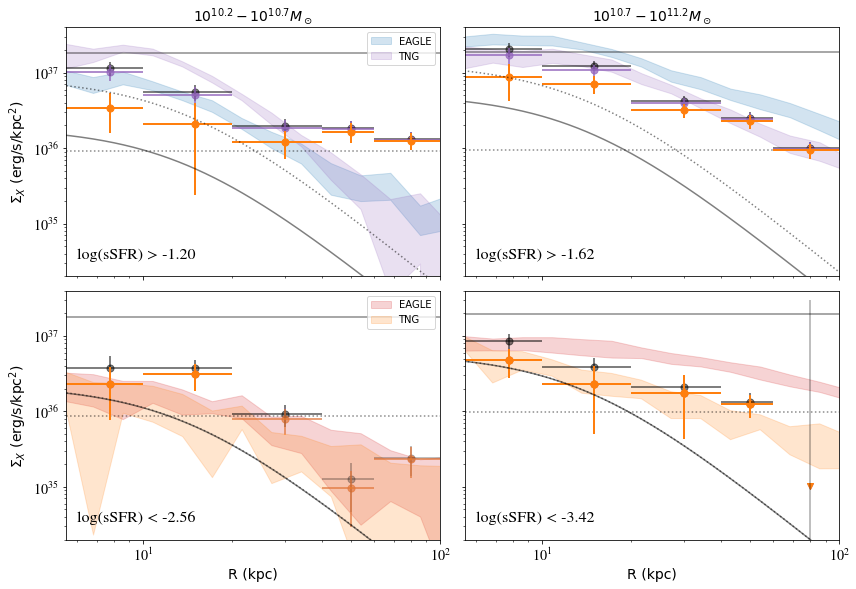

In [841]:
src = prof0520 #cut

high = src['logMass'] > 10.7
low = src['logMass'] < 10.7
highsf, highq = sort(src[high])
lowsf, lowq = sort(src[low])

print(src[low].iloc[lowsf]['ssfr'].min(), src[low].iloc[lowq]['ssfr'].max(), 
      src[high].iloc[highsf]['ssfr'].min(), src[high].iloc[highq]['ssfr'].max())
hsb_sf = sb_bkg(src[high].iloc[highsf]).value
hsb_q = sb_bkg(src[high].iloc[highq]).value
lsb_sf = sb_bkg(src[low].iloc[lowsf]).value
lsb_q = sb_bkg(src[low].iloc[lowq]).value
hsb_bck = sb_bkg(src[high]).value
lsb_bck = sb_bkg(src[low]).value

sb_err_high_sf_raw = sb_prof(src[high].iloc[highsf], mincts=-10)
sb_err_high_q_raw = sb_prof(src[high].iloc[highq], mincts=-10)
sb_err_low_sf_raw = sb_prof(src[low].iloc[lowsf], mincts=-10)
sb_err_low_q_raw = sb_prof(src[low].iloc[lowq], mincts=-10)

sb_err_high_sf_lxrb = sb_prof(src[high].iloc[highsf], xrb=True, beta=0, mincts=-10, alpha=6.713e28)
sb_err_high_q_lxrb = sb_prof(src[high].iloc[highq], xrb=True, beta=0, mincts=-10, alpha=6.713e28)
sb_err_low_sf_lxrb = sb_prof(src[low].iloc[lowsf], xrb=True, beta=0, mincts=-10, alpha=6.713e28)
sb_err_low_q_lxrb = sb_prof(src[low].iloc[lowq], xrb=True, beta=0, mincts=-10, alpha=6.713e28)

print('HXMB')
sb_err_high_sf_xrb = sb_prof(src[high].iloc[highsf], xrb=True, mincts=-10, alpha=6.713e28, beta=2.55e39)
sb_err_high_q_xrb = sb_prof(src[high].iloc[highq], xrb=True, mincts=-10, alpha=6.713e28, beta=2.55e39)
sb_err_low_sf_xrb = sb_prof(src[low].iloc[lowsf], xrb=True, mincts=-10, alpha=6.713e28, beta=2.55e39)
sb_err_low_q_xrb = sb_prof(src[low].iloc[lowq], xrb=True, mincts=-10, alpha=6.713e28, beta=2.55e39)

#Good! The XRB flux in the bins adds up to just less than the total, which includes r --> inf, so perfectly consistent.
fig, ax = plt.subplots(ncols=2,nrows=2,sharex=True, sharey=True, figsize=(12,8))
ax1, ax2,ax3,ax4 = ax.flatten()
plot_sim_profiles(lsb_sf, src[low].iloc[lowsf], ax1, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70fixed.sSFR.docalc.20.list.SB_stats.out',q=False, xrb=True,ls='dotted', label=True)
plot_sim_profiles(hsb_sf, src[high].iloc[highsf], ax2, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20fixed.sSFR.docalc.20.list.SB_stats.out', y=False,q=False, xrb=True,ls='dotted')

plot_sim_profiles(lsb_q, src[low].iloc[lowq], ax3, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70fixed.sSFR.docalc.20.list.SB_stats.out',sf=False, xrb=True, ls='dotted', label=True)
plot_sim_profiles(hsb_q, src[high].iloc[highq], ax4, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20fixed.sSFR.docalc.20.list.SB_stats.out', y=False,sf=False, xrb=True, ls='dotted')

plot_sim_profiles(lsb_sf, src[low].iloc[lowsf], ax1, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70fixed.sSFR.docalc.20.list.SB_stats.out',q=False, xrb=True, beta=0, alpha=0)
plot_sim_profiles(hsb_sf, src[high].iloc[highsf], ax2, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20fixed.sSFR.docalc.20.list.SB_stats.out', y=False,q=False, xrb=True, beta=0, alpha=0)

plot_sim_profiles(lsb_q, src[low].iloc[lowq], ax3, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70fixed.sSFR.docalc.20.list.SB_stats.out',sf=False, xrb=True, beta=0, alpha=0)
plot_sim_profiles(hsb_q, src[high].iloc[highq], ax4, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20fixed.sSFR.docalc.20.list.SB_stats.out', y=False,sf=False, xrb=True, beta=0, alpha=0)

plot(sb_err_low_sf_raw, ax1, 'k', nsigma=2, alpha=0.5, bkg=0.05*lsb_sf)
plot(sb_err_high_sf_raw, ax2, 'k', nsigma=2, alpha=0.5, bkg=0.05*hsb_sf)
plot(sb_err_low_q_raw, ax3, 'k', nsigma=2, alpha=0.5, bkg=0.05*lsb_q)
plot(sb_err_high_q_raw, ax4, 'k', nsigma=2, alpha=0.5, bkg=0.05*hsb_q)
plot(sb_err_low_sf_lxrb, ax1, 'tab:purple', nsigma=2, alpha=0.75, bkg=0.05*lsb_sf)
plot(sb_err_high_sf_lxrb, ax2, 'tab:purple', nsigma=2, alpha=0.75, bkg=0.05*hsb_sf)
plot(sb_err_low_q_lxrb, ax3, 'tab:purple', nsigma=2, alpha=0.75, bkg=0.05*lsb_q)
plot(sb_err_high_q_lxrb, ax4, 'tab:purple', nsigma=2, alpha=0.75, bkg=0.05*hsb_q)
plot(sb_err_low_sf_xrb, ax1, 'tab:orange', nsigma=2, bkg=0.05*lsb_sf)
plot(sb_err_high_sf_xrb, ax2, 'tab:orange', nsigma=2, bkg=0.05*lsb_q)
plot(sb_err_low_q_xrb, ax3, 'tab:orange', nsigma=2, bkg=0.05*hsb_sf)
plot(sb_err_high_q_xrb, ax4, 'tab:orange', nsigma=2, bkg=0.05*hsb_q)

plot(sb_err_high_q_xrb, ax4, 'tab:orange', nsigma=0, bkg=0.05*hsb_q, marker='^')
plt.ylim(2e34,4e37)
ax1.set_xlabel(''); ax2.set_xlabel(''); plt.tight_layout()
print(sb_err_high_q_xrb)
ax[0][0].set_title(r'$10^{10.2} - 10^{10.7} M_\odot$', fontsize=14)
ax[0][1].set_title(r'$10^{10.7} - 10^{11.2} M_\odot$', fontsize=14)
ax[0][0].text(6, 3.5e34, 'log(sSFR) > -1.20', fontsize=16, fontfamily='STIXGeneral')
ax[0][1].text(6, 3.5e34, 'log(sSFR) > -1.62', fontsize=16, fontfamily='STIXGeneral')
ax[1][0].text(6, 3.5e34, 'log(sSFR) < -2.56', fontsize=16, fontfamily='STIXGeneral')
ax[1][1].text(6, 3.5e34, 'log(sSFR) < -3.42', fontsize=16, fontfamily='STIXGeneral')

-1.20312941074371 -2.55801248550415 -1.61841905117035 -3.42206788063049
HXMB
[[ 0.00000000e+00  5.50000000e+00  5.26983707e+36  5.12356773e-01]
 [ 5.50000000e+00  1.00000000e+01  4.75287730e+36  4.19121182e-01]
 [ 1.00000000e+01  2.00000000e+01  2.27615690e+36  7.82720541e-01]
 [ 2.00000000e+01  4.00000000e+01  1.73469469e+36  7.48705289e-01]
 [ 4.00000000e+01  6.00000000e+01  1.24914279e+36  3.40873850e-01]
 [ 6.00000000e+01  1.00000000e+02 -7.84905318e+33 -7.02877562e+00]]


Text(6, 3.5e+34, 'log(sSFR) < -3.42')

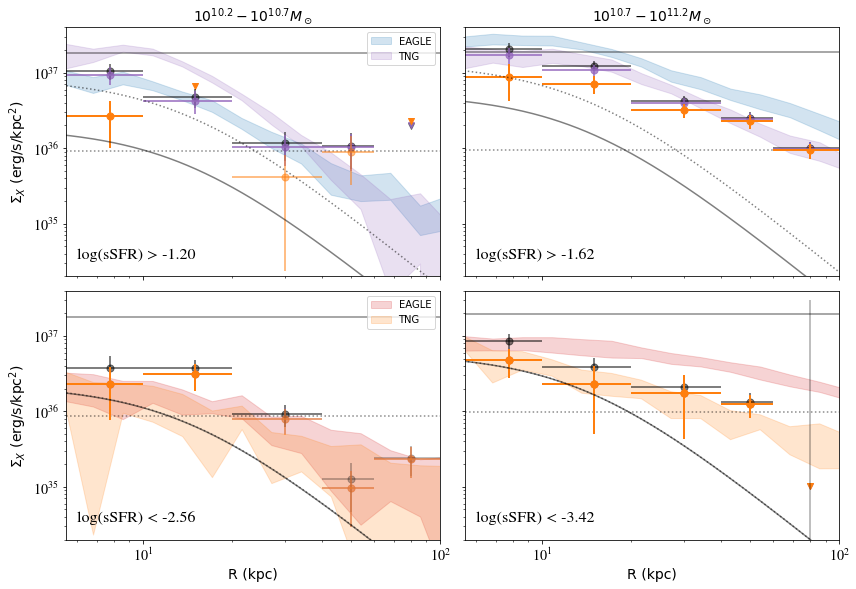

In [901]:
src = prof0520 

high = src['logMass'] > 10.7
low = src['logMass'] < 10.7
highsf, highq = sort(src[high])
lowsf, lowq = sort(src[low])

print(src[low].iloc[lowsf]['ssfr'].min(), src[low].iloc[lowq]['ssfr'].max(), 
      src[high].iloc[highsf]['ssfr'].min(), src[high].iloc[highq]['ssfr'].max())
hsb_sf = sb_bkg(src[high].iloc[highsf]).value
hsb_q = sb_bkg(src[high].iloc[highq]).value
lsb_sf = sb_bkg(src[low].iloc[lowsf]).value
lsb_q = sb_bkg(src[low].iloc[lowq]).value
hsb_bck = sb_bkg(src[high]).value
lsb_bck = sb_bkg(src[low]).value

sb_err_high_sf_raw = sb_prof(src[high].iloc[highsf], mincts=-10)
sb_err_high_q_raw = sb_prof(src[high].iloc[highq], mincts=-10)
sb_err_low_sf_raw = sb_prof(src[low].iloc[lowsf], mincts=-10, bkg_scale=1.05)
sb_err_low_q_raw = sb_prof(src[low].iloc[lowq], mincts=-10)

sb_err_high_sf_lxrb = sb_prof(src[high].iloc[highsf], xrb=True, beta=0, mincts=-10, alpha=6.713e28)
sb_err_high_q_lxrb = sb_prof(src[high].iloc[highq], xrb=True, beta=0, mincts=-10, alpha=6.713e28)
sb_err_low_sf_lxrb = sb_prof(src[low].iloc[lowsf], xrb=True, beta=0, mincts=-10, alpha=6.713e28, bkg_scale=1.05)
sb_err_low_q_lxrb = sb_prof(src[low].iloc[lowq], xrb=True, beta=0, mincts=-10, alpha=6.713e28)

print('HXMB')
sb_err_high_sf_xrb = sb_prof(src[high].iloc[highsf], xrb=True, mincts=-10, alpha=6.713e28, beta=2.55e39)
sb_err_high_q_xrb = sb_prof(src[high].iloc[highq], xrb=True, mincts=-10, alpha=6.713e28, beta=2.55e39)
sb_err_low_sf_xrb = sb_prof(src[low].iloc[lowsf], xrb=True, mincts=-10, alpha=6.713e28, beta=2.55e39, bkg_scale=1.05)
sb_err_low_q_xrb = sb_prof(src[low].iloc[lowq], xrb=True, mincts=-10, alpha=6.713e28, beta=2.55e39)

#Good! The XRB flux in the bins adds up to just less than the total, which includes r --> inf, so perfectly consistent.
fig, ax = plt.subplots(ncols=2,nrows=2,sharex=True, sharey=True, figsize=(12,8))
ax1, ax2,ax3,ax4 = ax.flatten()
plot_sim_profiles(lsb_sf, src[low].iloc[lowsf], ax1, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70fixed.sSFR.docalc.20.list.SB_stats.out',q=False, xrb=True,ls='dotted', label=True)
plot_sim_profiles(hsb_sf, src[high].iloc[highsf], ax2, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20fixed.sSFR.docalc.20.list.SB_stats.out', y=False,q=False, xrb=True,ls='dotted')

plot_sim_profiles(lsb_q, src[low].iloc[lowq], ax3, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70fixed.sSFR.docalc.20.list.SB_stats.out',sf=False, xrb=True, ls='dotted', label=True)
plot_sim_profiles(hsb_q, src[high].iloc[highq], ax4, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20fixed.sSFR.docalc.20.list.SB_stats.out', y=False,sf=False, xrb=True, ls='dotted')

plot_sim_profiles(lsb_sf, src[low].iloc[lowsf], ax1, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70fixed.sSFR.docalc.20.list.SB_stats.out',q=False, xrb=True, beta=0, alpha=0)
plot_sim_profiles(hsb_sf, src[high].iloc[highsf], ax2, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20fixed.sSFR.docalc.20.list.SB_stats.out', y=False,q=False, xrb=True, beta=0, alpha=0)

plot_sim_profiles(lsb_q, src[low].iloc[lowq], ax3, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70fixed.sSFR.docalc.20.list.SB_stats.out',sf=False, xrb=True, beta=0, alpha=0)
plot_sim_profiles(hsb_q, src[high].iloc[highq], ax4, simsfile='../BenData/SBprof_disp.EAGLE_TNG.Ms10.70_11.20fixed.sSFR.docalc.20.list.SB_stats.out', y=False,sf=False, xrb=True, beta=0, alpha=0)

plot(sb_err_low_sf_raw, ax1, 'k', nsigma=2, alpha=0.5, bkg=0.05*lsb_sf)
plot(sb_err_high_sf_raw, ax2, 'k', nsigma=2, alpha=0.5, bkg=0.05*hsb_sf)
plot(sb_err_low_q_raw, ax3, 'k', nsigma=2, alpha=0.5, bkg=0.05*lsb_q)
plot(sb_err_high_q_raw, ax4, 'k', nsigma=2, alpha=0.5, bkg=0.05*hsb_q)
plot(sb_err_low_sf_lxrb, ax1, 'tab:purple', nsigma=2, alpha=0.75, bkg=0.05*lsb_sf)
plot(sb_err_high_sf_lxrb, ax2, 'tab:purple', nsigma=2, alpha=0.75, bkg=0.05*hsb_sf)
plot(sb_err_low_q_lxrb, ax3, 'tab:purple', nsigma=2, alpha=0.75, bkg=0.05*lsb_q)
plot(sb_err_high_q_lxrb, ax4, 'tab:purple', nsigma=2, alpha=0.75, bkg=0.05*hsb_q)
plot(sb_err_low_sf_xrb, ax1, 'tab:orange', nsigma=2, bkg=0.05*lsb_sf)
plot(sb_err_high_sf_xrb, ax2, 'tab:orange', nsigma=2, bkg=0.05*lsb_q)
plot(sb_err_low_q_xrb, ax3, 'tab:orange', nsigma=2, bkg=0.05*hsb_sf)
plot(sb_err_high_q_xrb, ax4, 'tab:orange', nsigma=2, bkg=0.05*hsb_q)

plot(sb_err_high_q_xrb, ax4, 'tab:orange', nsigma=0, bkg=0.05*hsb_q, marker='^')
plt.ylim(2e34,4e37)
ax1.set_xlabel(''); ax2.set_xlabel(''); plt.tight_layout()
print(sb_err_high_q_xrb)
ax[0][0].set_title(r'$10^{10.2} - 10^{10.7} M_\odot$', fontsize=14)
ax[0][1].set_title(r'$10^{10.7} - 10^{11.2} M_\odot$', fontsize=14)
ax[0][0].text(6, 3.5e34, 'log(sSFR) > -1.20', fontsize=16, fontfamily='STIXGeneral')
ax[0][1].text(6, 3.5e34, 'log(sSFR) > -1.62', fontsize=16, fontfamily='STIXGeneral')
ax[1][0].text(6, 3.5e34, 'log(sSFR) < -2.56', fontsize=16, fontfamily='STIXGeneral')
ax[1][1].text(6, 3.5e34, 'log(sSFR) < -3.42', fontsize=16, fontfamily='STIXGeneral')

In [899]:
print(lsb_sf, lsb_q, hsb_sf, hsb_q)
# 1.957/1.833

1.8329330333806398e+37 1.7628155388394216e+37 1.9062748370528953e+37 1.9566759481659894e+37


In [751]:
sb_err_high_q_raw[:,-1], sb_err_high_q_lxrb[:,-1], sb_err_high_q_xrb[:,-1]

(array([  0.30065832,   0.23810855,   0.28846521,   0.42942074,
          0.31274018, -10.15607225]),
 array([ 0.67886927,  0.57095821,  2.0058809 ,  1.06513365,  0.36074416,
        -3.45782922]),
 array([ 0.67997579,  0.57199257,  2.02144955,  1.06717737,  0.36081581,
        -3.45488158]))

(19952623149.688828, 125892541179.41661)

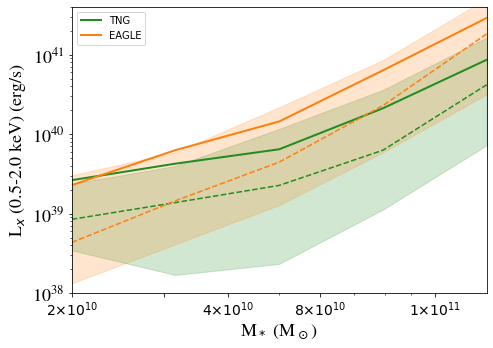

In [857]:
fig, ax = plt.subplots(figsize=(7,5))

# ax.scatter(10**mtng, Lx_tng, color='tab:orange', alpha=0.075)
# ax.scatter(10**meag, Lx_eag, color='darkgreen', alpha=0.075)

mean_tng = []
mean_eag = []
median_tng = []
median_eag = []
low_tng = []
low_eag = []
high_tng = []
high_eag = []

Mleft = np.linspace(10.2, 11.0, 5)
Mright = Mleft + 0.2

for i in range(len(Mright)):
    tng = Lx_tng[(mtng > Mleft[i])*(mtng < Mright[i])]
    eag = Lx_eag[(meag > Mleft[i])*(meag < Mright[i])]
    
    ssfrtng = tng0510[(mtng > Mleft[i])*(mtng < Mright[i])][:,5]
    ssfreag = eagle0510[(meag > Mleft[i])*(meag < Mright[i])][:,5]

    redtng = np.argsort(ssfrtng)[:int(len(tng)/3.)]
    bluetng = np.argsort(ssfrtng)[int(2*len(tng)/3.):]
    redeag = np.argsort(ssfreag)[:int(len(eag)/3.)]
    blueeag = np.argsort(ssfreag)[int(2*len(eag)/3.):]

    mean_tng.append(np.nanmean(tng))
    low_tng.append(np.nanpercentile(tng, 16))
    high_tng.append(np.nanpercentile(tng, 84))
    median_tng.append(np.nanmedian(tng))
    mean_eag.append(np.nanmean(eag))
    low_eag.append(np.nanpercentile(eag, 16))
    high_eag.append(np.nanpercentile(eag, 84))
    median_eag.append(np.nanmedian(eag))

mean_tng = np.array(mean_tng)
mean_eag = np.array(mean_eag)
low_tng = np.array(low_tng)
low_eag = np.array(low_eag)
high_tng = np.array(high_tng)
high_eag = np.array(high_eag)

ax.plot(10**((Mleft+Mright)/2), mean_tng, color='forestgreen', label='TNG', linewidth=2)
ax.plot(10**((Mleft+Mright)/2), mean_eag, color='tab:orange', label='EAGLE', linewidth=2)
ax.fill_between(10**((Mleft+Mright)/2), low_tng, high_tng, color='forestgreen', alpha=0.2)
ax.fill_between(10**((Mleft+Mright)/2), low_eag, high_eag, color='tab:orange', alpha=0.2)
ax.plot(10**((Mleft+Mright)/2), np.array(median_tng), color='forestgreen', linestyle='dashed')
ax.plot(10**((Mleft+Mright)/2), np.array(median_eag), color='tab:orange', linestyle='dashed')
ax.legend()
    
ax.set_yticks([1e38,1e40,1e42])
ax.set_yticklabels([r'10$^{38}$',r'10$^{40}$',r'10$^{42}$'],fontsize=18, fontfamily='STIXGeneral')
# ax.set_xticklabels(['',r'10$^{10}$',r'10$^{11}$','',''],fontsize=18, fontfamily='STIXGeneral')
ax.set_xlabel(r'M$_*$ (M$_\odot$)', fontfamily='STIXGeneral', fontsize=18)
ax.set_ylabel(r'L$_x$ (0.5-2.0 keV) (erg/s)', fontfamily='STIXGeneral', fontsize=18)
ax.figure.tight_layout()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xticks([2e10,3e10,4e10,6e10,1e11])
ax.set_xticklabels([r'2$\times10^{10}$','',r'4$\times10^{10}$',r'8$\times10^{10}$',r'1$\times10^{11}$'], fontsize=14)
ax.set_xlabel(r'M$_*$ (M$_\odot$)', fontfamily='STIXGeneral', fontsize=18)
ax.set_ylim(1e38,4e41)
ax.set_xlim(10**10.3,10**11.1)

In [132]:
print(mean_tng/median_tng, mean_eag/median_eag)

[3.10807435 3.09120771 2.84757178 3.37327194 2.06329965] [5.2687716  4.34157456 3.25146237 2.77768345 1.58948251]


The Eagle stacks evolve the most rapidly, followed by TNG and then observations. This could be because the Eagle stellar mass distribution is much steeper than that for TNG, which in turn agrees with SDSS. As a result, within the low-mass stack, Eagle is dominated by lower-mass galaxies, at the central mass bin they all agree, and at the highest mass it has only a handful of galaxies. 

## Surface Brightness Profiles

(0.0, 0.15)

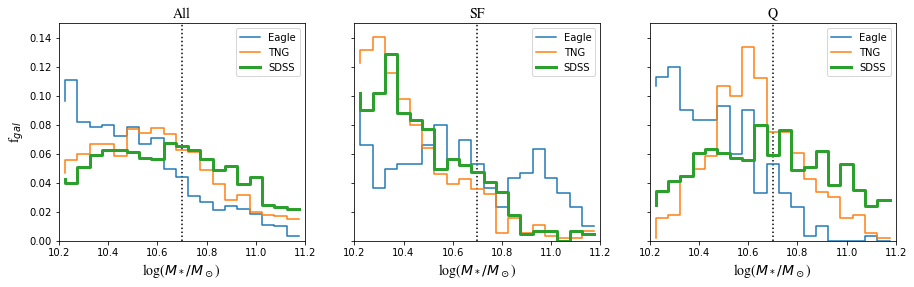

In [744]:
meag = eagle0510[:,3]
mtng = tng0510[:,3]
mobs = sdss['logMass']
fig, ax = plt.subplots(ncols = 3, sharex=True, sharey=True, figsize=(15,4))
ax1, ax2, ax3 = ax.flatten()
eag = eagle0510[:,5]
tng = tng0510[:,5]
eag_q = np.argsort(eag)[:int(len(eag)/3.)]
eag_sf = np.argsort(eag)[int(2*len(eag)/3.):]
tng_q = np.argsort(tng)[:int(len(tng)/3.)]
tng_sf = np.argsort(tng)[int(2*len(tng)/3.):]
q = np.argsort(sdss['ssfr'])[:int(len(mobs)/3.)]
sf = np.argsort(sdss['ssfr'])[int(2*len(mobs)/3.):]

def mhist(meag, mtng, mobs, ax=None, nbins=20):
    histeag, bins = np.histogram(meag, bins=nbins, range=(10.2, 11.2), density=True)
    histtng, bins = np.histogram(mtng, bins=nbins, range=(10.2, 11.2), density=True)
    histobs, bins = np.histogram(mobs, bins=nbins, range=(10.2, 11.2), density=True)
    if ax:
        ax.step((bins[1:]+bins[:-1])/2., histeag/sum(histeag), label='Eagle')
        ax.step((bins[1:]+bins[:-1])/2., histtng/sum(histtng), label='TNG')
        ax.step((bins[1:]+bins[:-1])/2., histobs/sum(histobs), label='SDSS',  linewidth=3)
        ax.legend()
        ax.set_xlim(10.2, 11.2)
        ax.set_xlabel(r'log($M_*/M_\odot$)', fontsize=14, fontfamily='STIXGeneral')
    else:
        return bins, histtng/histobs, histeag/histobs
    
mhist(meag, mtng, mobs, ax1)
mhist(meag[eag_sf], mtng[tng_sf], mobs[sf], ax2)
mhist(meag[eag_q], mtng[tng_q], mobs[q], ax3)
ax1.set_ylabel(r'f$_{gal}$', fontsize=14, fontfamily='STIXGeneral')
ax1.set_title('All', fontsize=14, fontfamily='STIXGeneral')
ax2.set_title('SF', fontsize=14, fontfamily='STIXGeneral')
ax3.set_title('Q', fontsize=14, fontfamily='STIXGeneral')
for a in ax.flatten():
    a.vlines(10.7, 0, .16, color='k', linestyle='dotted')
ax1.set_ylim(0,.15)

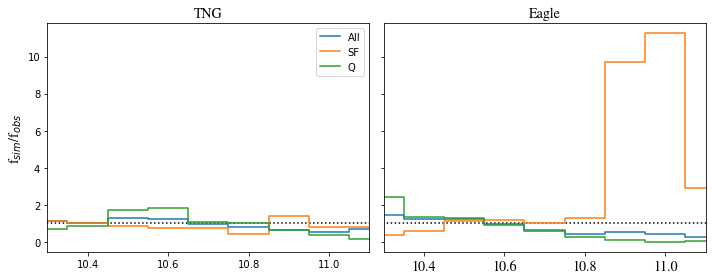

In [745]:
bins, ftng, feag = mhist(meag, mtng, mobs, nbins=10)
bins, ftng_sf, feag_sf = mhist(meag[eag_sf], mtng[tng_sf], mobs[sf], nbins=10)
bins, ftng_q, feag_q = mhist(meag[eag_q], mtng[tng_q], mobs[q], nbins=10)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10,4))
ax[0].step((bins[1:]+bins[:-1])/2., ftng, label='All')
ax[0].step((bins[1:]+bins[:-1])/2., ftng_sf, label='SF')
ax[0].step((bins[1:]+bins[:-1])/2., ftng_q, label='Q')

ax[1].step((bins[1:]+bins[:-1])/2., feag, label='All')
ax[1].step((bins[1:]+bins[:-1])/2., feag_sf, label='SF')
ax[1].step((bins[1:]+bins[:-1])/2., feag_q, label='Q')

ax[0].legend()
ax[0].set_title('TNG', fontsize=14, fontfamily='STIXGeneral')
ax[1].set_title('Eagle', fontsize=14, fontfamily='STIXGeneral')
ax[0].set_ylabel(r'f$_{sim}$/f$_{obs}$', fontsize=14, fontfamily='STIXGeneral')
ax[0].hlines(1, 10.2, 11.2, color='k', linestyle='dotted')
ax[1].hlines(1, 10.2, 11.2, color='k', linestyle='dotted')
plt.xlim(10.3,11.1)
plt.xticks([10.4,10.6,10.8,11.0], fontsize=14, fontfamily='STIXGeneral')
# plt.yticks([2,4,6,8], fontsize=14, fontfamily='STIXGeneral')
plt.tight_layout()

For every galaxy simulated, we actually observe this many ^ galaxies. I.e. the simulated galaxy needs to be multiplied by this much before adding. The dashed line shows 1, i.e. a no correction needed.

In [749]:
conversions = np.zeros((10,7))
conversions[:,0] = (bins[1:] + bins[:-1])/2.
conversions[:,1] = ftng
conversions[:,2] = ftng_sf
conversions[:,3] = ftng_q
conversions[:,4] = feag
conversions[:,5] = feag_sf
conversions[:,6] = feag_q
np.savetxt('conversions.csv', conversions, delimiter=',')

In [763]:
def xrb_psf(sdss, alpha = 9.05e28, beta = 1.62e39, fit=fit, area_psf=area_psf):
		norm = Lxrb(sdss,alpha=alpha,beta=beta).mean()
		xp = np.arange(0,100,.1)
		yp = psf_curve(xp, *fit)/area_psf
		return xp, yp,norm


In [568]:
lcts = np.load('../lcts_0520.npy')[:1482]
lexp = np.load('../lexp_0520.npy')[:1482]/5
larea = np.load('../larea_0520.npy')[:1482]
hcts = np.load('../hcts_0520.npy')
hexp = np.load('../hexp_0520.npy')/5
harea = np.load('../harea_0520.npy')
lradec = np.load('../lradec.npy')
hradec = np.load('../hradec.npy')
inds1 = crossmatch(lradec, sdss, arr=True, tab=False)
inds2 = crossmatch(hradec, sdss, arr=True, tab=False)
larea_kpc, lnet_cts, ldcorr, lsb_bkg = profiles(lcts, larea, lexp, sdss[inds1], log=True)
harea_kpc, hnet_cts, hdcorr, hsb_bkg = profiles(hcts, harea, hexp, sdss[inds2], log=True)

<ipython-input-525-30285c6f622a>:33: RuntimeWarning: invalid value encountered in true_divide
  bk_rate     = (cts[i,-bckcols:]/area[i,-bckcols:])
<ipython-input-525-30285c6f622a>:40: RuntimeWarning: invalid value encountered in true_divide
  bkg = np.nanmean(rows[i,-bckcols:]/area[i,-bckcols:]) * area[i,j]
<ipython-input-525-30285c6f622a>:40: RuntimeWarning: Mean of empty slice
  bkg = np.nanmean(rows[i,-bckcols:]/area[i,-bckcols:]) * area[i,j]
<ipython-input-525-30285c6f622a>:44: RuntimeWarning: invalid value encountered in true_divide
  sb = np.nansum(net_cts/area_kpc,axis=0) / np.nansum(exp, axis=0)
<ipython-input-525-30285c6f622a>:48: RuntimeWarning: invalid value encountered in true_divide
  sb_bkg = np.nanmean(rows[:,-bckcols:]/(area[:,-bckcols:]*exp[:,-bckcols:]))


In [537]:
np.nansum(lnet_cts[:,:-1])/1230., np.nansum(hnet_cts[:,:-1])/954.

(0.03694499586350504, 1.0887255065313237)

In [776]:
def plot_sim_profiles(sb_bkg, sdss, ax, simsfile = 'BenData/SBprof_disp.EAGLE_TNG.Ms10.20_10.70fixed.sSFR.docalc.20.list.SB_stats.out', 
	cts_to_erg = 1.624e-12,color='tab:blue', ls='solid',bckcols=1, xrb=False, beta=1.62e39, alpha_xrb=6.713e28, y=True, q=True, sf=True,alpha=0.2, label=False):

	ax.hlines(sb_bkg, 0,200, color='k', alpha=0.25)
	ax.hlines(0.05*sb_bkg, 0,200, color='k', alpha=0.25, linestyle='dotted')
	
	if simsfile:
		sims = np.genfromtxt(simsfile)
		yconv=3.1e39
		if sf:
			ax.fill_between(sims[:,0],sims[:,2]*yconv,sims[:,3]*yconv,color='tab:blue',alpha=alpha, label='EAGLE')
			ax.fill_between(sims[:,0],sims[:,8]*yconv,sims[:,9]*yconv,color='tab:purple',alpha=alpha, label='TNG')
		if q:
			ax.fill_between(sims[:,0],sims[:,5]*yconv,sims[:,6]*yconv,color='tab:red',alpha=alpha, label='EAGLE')
			ax.fill_between(sims[:,0],sims[:,-2]*yconv,sims[:,-1]*yconv,color='tab:orange',alpha=alpha, label='TNG')
		format_plot(ax, y=y)
		if label:
			ax.legend(loc='best')    

	if xrb:
		xp, yp, norm = xrb_psf(sdss, beta=beta, alpha=alpha_xrb)
		sbxrb = yp*norm
		ax.plot(xp, sbxrb, c='k', label=r'XRB $\times$ PSF', linestyle=ls, alpha=0.5)

In [177]:
def format_plot(ax, yconv=3.1e39,y=True):
	ax.set_xlabel('R (kpc)', fontsize=14)
	ax.set_xlim(5.5,100)
	ax.set_xscale('log')
	ax.set_yscale('log')
	ax.set_ylim(3e33, 4e37)
	if y:
		ax.set_ylabel(r'$\Sigma_X$ (erg/s/kpc$^2$)',fontsize=14)
	for y in ax.get_yticklabels(): 
		y.set_fontfamily('STIXGeneral')
		y.set_fontsize(14)
	for x in ax.get_xticklabels(): 
		x.set_fontfamily('STIXGeneral')
		x.set_fontsize(14)
	plt.tight_layout()


In [ ]:
sdss[inds1]['z'].mean()

In [976]:
# larea_kpc, lnet_cts1, ldcorr, lsb_bkg = profiles(lcts, larea, lexp, sdss[inds1], log=True, xrb=True, beta=0)
# harea_kpc, hnet_cts1, hdcorr, hsb_bkg = profiles(hcts, harea, hexp, sdss[inds2], log=True, xrb=True, beta=0)

# larea_kpc, lnet_cts2, ldcorr, lsb_bkg = profiles(lcts, larea, lexp, sdss[inds1], log=True, xrb=True)
# harea_kpc, hnet_cts2, hdcorr, hsb_bkg = profiles(hcts, harea, hexp, sdss[inds2], log=True, xrb=True)

# lsb1, lerr1 = sb_err(lnet_cts1, lcts, lexp, larea_kpc, ldcorr)
# hsb1, herr1 = sb_err(hnet_cts1, hcts, hexp, harea_kpc, hdcorr)
# lsb2, lerr2 = sb_err(lnet_cts2, lcts, lexp, larea_kpc, ldcorr)
# hsb2, herr2 = sb_err(hnet_cts2, hcts, hexp, harea_kpc, hdcorr)

<ipython-input-525-30285c6f622a>:33: RuntimeWarning: invalid value encountered in true_divide
  bk_rate     = (cts[i,-bckcols:]/area[i,-bckcols:])
<ipython-input-525-30285c6f622a>:40: RuntimeWarning: Mean of empty slice
  bkg = np.nanmean(rows[i,-bckcols:]/area[i,-bckcols:]) * area[i,j]
<ipython-input-525-30285c6f622a>:40: RuntimeWarning: invalid value encountered in true_divide
  bkg = np.nanmean(rows[i,-bckcols:]/area[i,-bckcols:]) * area[i,j]
<ipython-input-525-30285c6f622a>:48: RuntimeWarning: invalid value encountered in true_divide
  sb_bkg = np.nanmean(rows[:,-bckcols:]/(area[:,-bckcols:]*exp[:,-bckcols:]))


In [808]:
# larea_kpc_b, lnet_cts_b2, ldcorr_b, lsb_bkg = profiles(lcts[top1], larea[top1], lexp[top1], sdss[inds1][top1], log=True, xrb=True)
# larea_kpc_r, lnet_cts_r2, ldcorr_r, lsb_bkg = profiles(lcts[bottom1], larea[bottom1], lexp[bottom1], sdss[inds1][bottom1], log=True)

# harea_kpc_b, hnet_cts_b2, hdcorr_b, hsb_bkg = profiles(hcts[top2], harea[top2], hexp[top2], sdss[inds2][top2], log=True, xrb=True)
# harea_kpc_r, hnet_cts_r2, hdcorr_r, hsb_bkg = profiles(hcts[bottom2], harea[bottom2], hexp[bottom2], sdss[inds2][bottom2], log=True, xrb=True)

# lsb_b2, lerr_b2 = sb_err(lnet_cts_b2, lcts[top1], lexp[top1], larea_kpc_b, ldcorr_b)
# hsb_b2, herr_b2 = sb_err(hnet_cts_b2, hcts[top2], hexp[top2], harea_kpc_b, hdcorr_b)
# lsb_r2, lerr_r2 = sb_err(lnet_cts_r2, lcts[bottom1], lexp[bottom1], larea_kpc_r, ldcorr_r)
# hsb_r2, herr_r2 = sb_err(hnet_cts_r2, hcts[bottom2], hexp[bottom2], harea_kpc_r, hdcorr_r)

<ipython-input-525-30285c6f622a>:33: RuntimeWarning: invalid value encountered in true_divide
  bk_rate     = (cts[i,-bckcols:]/area[i,-bckcols:])
<ipython-input-525-30285c6f622a>:40: RuntimeWarning: Mean of empty slice
  bkg = np.nanmean(rows[i,-bckcols:]/area[i,-bckcols:]) * area[i,j]
<ipython-input-525-30285c6f622a>:40: RuntimeWarning: invalid value encountered in true_divide
  bkg = np.nanmean(rows[i,-bckcols:]/area[i,-bckcols:]) * area[i,j]
<ipython-input-525-30285c6f622a>:48: RuntimeWarning: invalid value encountered in true_divide
  sb_bkg = np.nanmean(rows[:,-bckcols:]/(area[:,-bckcols:]*exp[:,-bckcols:]))
<ipython-input-525-30285c6f622a>:44: RuntimeWarning: invalid value encountered in true_divide
  sb = np.nansum(net_cts/area_kpc,axis=0) / np.nansum(exp, axis=0)


In [893]:
#great! now just add the observed points. This requires rebinning the net_cts. Or perhaps extracting them in different annuli
def rebin(cts, net_cts, area_kpc, exp, dcorr, xi, xmin, xmax, cts_to_erg = 1.624e-12*7/5):
	x = (xi[1:]+xi[:-1])/2.
	imin = np.argmin(abs(x-xmin))
	imax = np.argmin(abs(x-xmax))
	print(imin, imax)
	sub_cts = cts[:, imin:imax+1]
	sub_net = net_cts[:, imin:imax+1]
	sub_area = area_kpc[:, imin:imax+1]
	sub_exp = exp[:, imin:imax+1]
	sb = np.nansum(sub_net/sub_area)/np.nansum(sub_exp)
	sb *= cts_to_erg * np.mean(dcorr.value)
	err = np.sqrt(np.nansum(sub_cts))/np.nansum((sub_net))
	return xi[imin], xi[imax+1], sb, err

In [753]:
def plot(sb_err, ax, color, nsigma=1, alpha=1, lw=2, bkg=0,marker='v'):
    x = (sb_err[:,0] + sb_err[:,1])/2.
    xerr = (sb_err[:,0] - sb_err[:,1])/2.
    sb = sb_err[:,2]
    err = sb_err[:,3]
    valid = (sb > 0)*(err < 1)
    confident = (sb > bkg)
    iffy = (sb < bkg)
    ax.errorbar(x[valid*confident], sb[valid*confident], xerr=xerr[valid*confident], yerr=(sb*err)[valid*confident], color=color, alpha=alpha, linewidth=0, elinewidth=lw)
    ax.scatter(x[valid*confident], sb[valid*confident], s=50, color=color, alpha=alpha)
    ax.errorbar(x[valid*iffy], sb[valid*iffy], xerr=xerr[valid*iffy], yerr=(sb*err)[valid*iffy], color=color, alpha=alpha/2., linewidth=0, elinewidth=lw)
    ax.scatter(x[valid*iffy], sb[valid*iffy], s=50, color=color, alpha=alpha/2.)
    ax.scatter(x[~valid], sb[~valid]*(1+nsigma*err[~valid]), color=color, marker=marker, alpha=alpha)

In [1163]:
def construct_table(cts, exp, area, radec):
    src = pd.DataFrame()
    src.insert(0, 'ra', radec[:,0])
    src.insert(1, 'dec', radec[:,1])
    src.insert(2, 'z', sdss.iloc[inds]['z'].values)
    src.insert(3, 'logMass', sdss.iloc[inds]['logMass'].values)
    src.insert(4, 'ssfr', sdss.iloc[inds]['ssfr'].values)
    src.insert(5, 'cts-0-5.5', cts[:, 0])
    src.insert(6, 'cts-5.5-10', cts[:, 1])
    src.insert(7, 'cts-10-20', cts[:, 2])
    src.insert(8, 'cts-20-40', cts[:, 3])
    src.insert(9, 'cts-40-60', cts[:, 4])
    src.insert(10, 'cts-60-100', cts[:, 5])
    src.insert(11, 'bck-cts', cts[:, 6])
    src.insert(12, 'exp-0-5.5', exp[:,0])
    src.insert(13, 'exp-5.5-10', exp[:,1])
    src.insert(14, 'exp-10-20', exp[:,2])
    src.insert(15, 'exp-20-40', exp[:,3])
    src.insert(16, 'exp-40-60', exp[:,4])
    src.insert(17, 'exp-60-100', exp[:,5])
    src.insert(18, 'bck-exp', exp[:,6])
    src.insert(19, 'area-0-5.5', area[:,0])
    src.insert(20, 'area-5.5-10', area[:,1])
    src.insert(21, 'area-10-20', area[:,2])
    src.insert(22, 'area-20-40', area[:,3])
    src.insert(23, 'area-40-60', area[:,4])
    src.insert(24, 'area-60-100', area[:,5])
    src.insert(25, 'bck-area', area[:,6])
    return src

(7.888016571050706e+28, 3.605519214113673e+39)

In [892]:
 def sb_prof(tab, alpha = 9.05e28, beta = 1.62e39, xrb=False, 
             cts_to_erg=1.624e-12, debug=False, tot=False, mincts=-1e5, bkg_scale=1):
        rs = ['0-5.5','5.5-10','10-20','20-40','40-60','60-100']
        sb_err = np.zeros((len(rs), 4))
        dl2 = 4*np.pi*(lcdm.angular_diameter_distance(tab['z']).to('cm'))**2
        if tot:
            cts_tot = 0
            net_cts_tot = 0
            lx_tot = 0
        for i in range(len(rs)):
            rmin = float(rs[i].split('-')[0])
            rmax = float(rs[i].split('-')[1])
            sb_err[i,0] = rmin
            sb_err[i,1] = rmax
            cts = tab['cts-'+rs[i]]
            area = tab['area-'+rs[i]]
            exp = tab['exp-'+rs[i]]
            if np.nansum(area) and np.nansum(exp):
                bkg_rt = tab['bck-cts']/(tab['bck-area']*tab['bck-exp'])
                bkg_rt = np.nanmedian(bkg_rt[bkg_rt>-10])
                bkg_rt *= bkg_scale
                net_cts = cts - bkg_rt*area*exp
                if xrb:
                    xp, yp, norm = xrb_psf(tab, beta=beta, alpha=alpha)
                    dA = np.insert(np.pi*(xp[1:]**2 - xp[:-1]**2), 0, 0)
    #                 mask = (xp > rmin)*(xp < rmax)
                    rmean = (rmin+rmax)/2.
                    ind = np.argmin(abs(xp - rmean))
    #                 lxrb, _ = quad(psf_area, a=rmin, b=rmax,args=(fit_xrb, fit[1], fit[2]))
    #                 lxrb = np.sum(norm*yp[mask]*dA[mask])
                    lxrb = yp[ind]*norm*np.nanmean(area)
    #                 print(yp.max())
                    xrb_cts = lxrb*exp/(cts_to_erg * dl2.value)
                    net_cts -= xrb_cts
                    if debug:
                        print(rmin, '-', rmax,' :', np.nansum(net_cts+xrb_cts), np.nansum(xrb_cts))
                
                sb_err[i,2] = np.nansum((net_cts * dl2.value))/(np.nanmean(area)*np.nansum(exp)) * cts_to_erg 
                sb_err[i,3] = np.sqrt(np.nansum(cts))/np.nansum(net_cts)
                if tot:
                    if rmin:
                        if np.nansum(net_cts) > mincts:
                            cts_tot += np.nansum(cts)
                            net_cts_tot += np.nansum(net_cts)
                            lx_tot += np.nansum(net_cts* dl2.value)* cts_to_erg 
                        
        if tot:
            lx_tot /= np.nansum(exp) 
            err_tot = np.sqrt(np.nansum(cts_tot))/np.nansum(net_cts_tot)
            return lx_tot, err_tot
        else:
            return sb_err

I think what we're learning here is that the XRB model is fairly conservative. If it completely removes central emission but leaves emission in the outskirts (high mass, quenched; low-mass SF), those outer detections are very robust. Conversely, if it retains central emission but is dim in the outskirts (low mass, quenched), the outskirts are definitely undetected. 

I do think there is a 

In [1150]:
psf = {}
for (e, r) in zip(eef,cdf):
    psf[e] = r

In [1151]:
psf

{0.4: 2.3682704,
 0.45: 2.676496,
 0.5: 3.0556135,
 0.55: 3.492052,
 0.6: 4.041087,
 0.6499999999999999: 4.647543,
 0.7: 5.309737,
 0.75: 6.1029196,
 0.7999999999999999: 7.200887,
 0.8499999999999999: 8.627701,
 0.8999999999999999: 10.747527,
 0.9499999999999998: 15.137898}

3.2


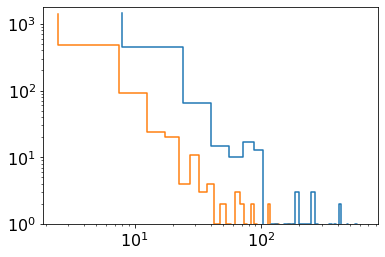

In [883]:
ratio = (100**2 - 60**2)/(60**2 - 40**2)
cmin = 0; cmax=200
print(ratio)
h1, b1 = np.histogram(prof0520['cts-40-60'], bins=int((cmax-cmin)/5), range=(cmin,cmax))
h2, b2 = np.histogram(prof0520['cts-60-100'], bins=int((cmax-cmin)/5), range=(cmin*ratio,cmax*ratio))

plt.step((b1[:-1]+b1[1:])/2., h1, color='tab:orange')
plt.step((b2[:-1]+b2[1:])/2., h2, color='tab:blue')
plt.yscale('log')
plt.ylim(1,1800)
plt.xscale('log')

In [889]:
# weird = np.argwhere(prof0520['cts-40-60'].values>200).flatten()
# weird2 = np.argwhere(prof0520['cts-60-100'].values>200).flatten()
# len(weird2), prof0520.iloc[weird2]['logMass'], prof0520.iloc[weird2]['ssfr']#, prof0520.iloc[weird]
top, bottom = sort(prof0520[prof0520['logMass'] < 10.7])
sf = prof0520[prof0520['logMass'] < 10.7].iloc[top]
q = prof0520[prof0520['logMass'] < 10.7].iloc[bottom]
weird = np.argwhere(q['cts-60-100'].values>20).flatten()
weird2 = np.argwhere(sf['cts-60-100'].values>20).flatten()
# print(sf.iloc[weird2]['ra'],sf.iloc[weird2]['dec'])#, sf.iloc[weird]['ra'], sf.iloc[weird]['dec'])
hotgals = np.zeros((len(weird2)+len(weird),2))
hotgals[:,0] = np.concatenate((sf.iloc[weird2]['ra'], q.iloc[weird]['ra']))
hotgals[:,1] = np.concatenate((sf.iloc[weird2]['dec'], q.iloc[weird]['dec']))
inds = crossmatch(hotgals, prof0520, arr=True)
print((inds,prof0520.iloc[inds].index))
# print(sf['ssfr'].min(), len(top), len(bottom))
cut = prof0520
for ind in prof0520.iloc[inds].index:
    cut = cut.drop(ind,axis=0)

print(len(inds), len(sf))
#why is this affecting the QUENCHED stack??

([886, 1103, 1234, 1422, 1611, 1911, 1049, 1392, 1930, 497, 287, 984, 793, 618, 994, 1588, 949, 1466, 1619, 1932, 1217, 154, 933, 1802, 1490, 1962, 256, 79, 13, 370, 1294, 834, 1055, 334, 1375, 1363, 1186, 768, 29, 697, 1974, 1828, 1770, 909, 455, 1564, 327, 417, 130, 1948, 1057, 1971, 1209, 884, 322, 1616, 664, 876, 1800, 616, 1993, 942, 1677, 1380, 1817, 638, 1696, 183, 1706, 1161, 1382, 525, 990, 811, 134, 1968, 496, 1519, 777, 1078, 1875, 131, 1558, 1573, 27, 240, 1446, 1733, 767, 1498, 808, 1963, 989, 132, 414, 1306, 359, 472, 1746, 1062, 297, 815, 816, 1420, 1473, 2027, 527, 1431, 1485, 32, 857, 671, 388, 479, 1615, 544, 1692, 1002, 200, 259, 169], Int64Index([1418, 1777, 1994, 2303, 2604, 3054, 1686, 2254, 3086,  770,
            ...
            1064,  600,  739, 2608,  845, 2723, 1612,  308,  396,  257],
           dtype='int64', length=121))
121 384


In [1216]:
def hardness(src, src0510):
    net_cts = src['cts-0-10'] - src['bck-cts']*src['area-0-5.5']*src['exp-0-5.5']/(src['bck_area']*src['bck-exp'])
    net_cts0510 = src0510['cts-0-10'] - src0510['bck-cts']*src0510['area-0-5.5']*src0510['exp-0-5.5']/(src0510['bck_area']*src0510['bck-exp'])
    return(np.nansum(net_cts)/np.nansum(net_cts0510) - 1)

In [872]:
def cts_area_ratio(tab, prof=False):
	if prof:
		cts = (tab['cts-0-5.5']+tab['cts-5.5-10']).sum()
		bck_cts = tab['bck-cts'].sum()
		area = tab['bck-area']/(tab['area-0-5.5']+tab['area-5.5-10'])
	else:
		cts = tab['cts'].sum()
		bck_cts = tab['bck-cts'].sum()
		area = tab['bck-area']/tab['area']
	return cts, bck_cts, np.nanmean(area[area<np.inf])

def hardness_ratio(hard,soft, prof=False):
	softsrc, softbck, softarea = cts_area_ratio(soft, prof=prof)
	allsrc, allbck, allarea = cts_area_ratio(hard, prof=prof) 
	print(int(softsrc), int(softbck), softarea, int(allsrc-softsrc), int(allbck-softbck), allarea)
	return int(softsrc), int(softbck), softarea, int(allsrc-softsrc), int(allbck-softbck), allarea

src0520 = pd.read_csv('../src_bck_cts.csv')
src0510 = pd.read_csv('../src_bck_cts_0510.csv')
print('low mass, 10-100: '); hardness_ratio(src0520[src0520['logMass'] < 10.7], src0510[src0510['logMass'] < 10.7], prof=False)
print('high mass, 10-100: ');hardness_ratio(src0520[src0520['logMass'] > 10.7], src0510[src0510['logMass'] > 10.7], prof=False)
# print('low mass, 0-10: ');hardness_ratio(prof0520[prof0520['logMass'] < 10.7], prof0510[prof0520['logMass'] < 10.7], prof=True)
# print('high mass, 0-10: ');hardness_ratio(prof0520[prof0520['logMass'] > 10.7], prof0510[prof0520['logMass'] > 10.7], prof=True)

low mass, 10-100: 
20802 23019 1.2142878669646995 9120 10326 1.2142878669646995
high mass, 10-100: 
16203 17380 1.1538900382047819 7370 7661 1.1538900382047819


(16203, 17380, 1.1538900382047819, 7370, 7661, 1.1538900382047819)

In [863]:
prof0520 = pd.read_csv('../src_broad_0520.csv')
prof0510 = pd.read_csv('../src_broad_0510.csv')
prof0520 = prof0520[(prof0520['logMass'] > 10.2)*(prof0520['logMass'] < 11.2)]
prof0510 = prof0520[(prof0510['logMass'] > 10.2)*(prof0510['logMass'] < 11.2)]
ar = prof0520['area-0-5.5']+prof0520['area-5.5-10']
print((prof0520['bck-area'][ar>0]/ar[ar>0]).mean())
#this makes sense 

134.17764976183068


<ipython-input-863-d61ffc4e4bbc>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prof0510 = prof0520[(prof0510['logMass'] > 10.2)*(prof0510['logMass'] < 11.2)]


In [158]:
(150**2 - 100**2)/10**2 #expected ratio if nothing were masked

125.0

In [877]:
low0520 = prof0520[prof0520['logMass'] < 10.7]
lowsf, lowq = sort(low0520)
low0510 = prof0510[prof0510['logMass'] < 10.7]
lowsfsoft, lowqsoft = sort(low0510)
high0520 = prof0520[prof0520['logMass'] > 10.7]
highsf, highq = sort(high0520)
high0510 = prof0510[prof0510['logMass'] > 10.7]
highsfsoft, highqsoft = sort(high0510)
low0510['cts-0-5.5'].sum()+low0510['cts-5.5-10'].sum()
low0510['cts-0-5.5'].sum()+low0510['cts-5.5-10'].sum()

478.45403481274843

In [878]:
 hardness_ratio(low0520.iloc[lowsf], low0510.iloc[lowsfsoft], prof=True)

135 9906 133.27342385753022 0 0 133.27342385753022


(135, 9906, 133.27342385753022, 0, 0, 133.27342385753022)

In [880]:
low0510.iloc[lowsfsoft]

,ra,dec,z,logMass,ssfr,cts-0-5.5,cts-5.5-10,cts-10-20,cts-20-40,cts-40-60,...,exp-40-60,exp-60-100,bck-exp,area-0-5.5,area-5.5-10,area-10-20,area-40-60,area-20-40,area-60-100,bck-area
398,144.370356,-0.289412,0.050729,10.450471,-1.203129,0.0,0.000000,0.000000,0.000000,0.000000,...,156.701193,153.561601,152.389566,112.0,192.0,896.0,6000.0,3584.0,19184.0,37328.0
193,138.628093,4.929252,0.055933,10.634083,-1.203129,0.0,0.074539,3.329736,3.689237,9.229069,...,1337.527228,1337.846553,1339.622975,96.0,160.0,720.0,5040.0,3008.0,15904.0,31120.0
1418,139.665081,1.755972,0.058886,10.254153,-1.199836,0.0,0.000000,0.000000,6.000000,4.922012,...,1477.107772,1477.035824,1475.839365,64.0,160.0,672.0,4528.0,2736.0,14448.0,28320.0
1941,139.359074,3.306831,0.072372,10.502064,-1.193260,0.0,0.815834,1.021145,3.947290,4.209640,...,1395.815930,1395.754523,1395.641743,48.0,96.0,464.0,2976.0,1872.0,8864.0,19216.0
3049,141.940445,2.166613,0.071206,10.472387,-1.190295,0.0,0.000000,0.000000,0.000000,3.699430,...,1331.498671,1331.886719,1334.657756,48.0,96.0,480.0,3168.0,1920.0,10208.0,19728.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840,132.741863,3.863059,0.076528,10.227782,-0.299360,0.0,0.000000,2.000000,6.000000,1.000000,...,1263.034557,1258.775139,1255.155957,32.0,96.0,448.0,2816.0,1648.0,8944.0,17072.0
38,142.875513,0.643769,0.070307,10.239193,-0.299360,0.0,0.000000,0.000000,4.062047,2.965189,...,1400.267304,1400.187861,1399.978069,64.0,128.0,464.0,3344.0,1968.0,10384.0,20432.0
2464,141.984998,3.250355,0.093001,10.402464,-0.290558,0.0,0.000000,0.000000,1.000000,3.544209,...,1282.351379,1284.357012,1286.400016,16.0,96.0,272.0,2000.0,1184.0,6240.0,12272.0
2379,139.620303,-0.535921,0.085176,10.356048,-0.282896,0.0,0.261628,3.020483,5.787958,6.557929,...,1777.085705,1774.361410,1770.730527,32.0,80.0,352.0,2288.0,1408.0,7296.0,13408.0


In [902]:
np.nanmedian(src0520['bck-area'])/np.nanmedian(src0520['area'])

1.1082402234636872